In [316]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

In [317]:
# Sorting code from Meng

from random import choice

def permuteOrder(df,axis,switch = 0):
    penaltyMat = np.zeros((df.shape[0],df.shape[1]))
    for i in range(penaltyMat.shape[0]):
        for j in range(penaltyMat.shape[1]):
            penaltyMat[i,j] = np.abs(i-(df.shape[0])/(df.shape[1])*j)**0.5
    if axis == 0:
        sort = df.index.values.copy()
    elif axis == 1:
        sort = df.columns.values.copy()
    dfCopy = df.values.copy()
#     print(dfCopy)
    for i in range(df.shape[int(axis)]):
        penalty = np.full((df.shape[int(axis)]),np.inf)
        for j in range(len(penalty)):
            tempMat = dfCopy.copy()
            if axis == 0:
                tempMat[[i, j],:] = tempMat[[j, i],:]
            elif axis == 1:
                tempMat[:,[i, j]] = tempMat[:,[j, i]]
            penalty[j] = sum(sum(tempMat*penaltyMat))
        idx = np.argmin(penalty)
        if not idx == i:                
            switch += 1
        if axis == 0:
            dfCopy[[i, idx], :] = dfCopy[[idx, i], :];
        elif axis == 1:
            dfCopy[:,[i, idx]] = dfCopy[:,[idx, i]];
        else:
            print('bad axis {}'.format(axis))
        sort[[i, idx]] = sort[[idx, i]]
    return switch,sort

def runPermutation(df, axis = 'Both', maxIter = 100,maxTrys = 9):  # initial maxTrys = 5
    iterations = 0
    trys = 0
    sortedDF = df.copy(deep=True)
    while iterations < maxIter:
        if axis == 'Both':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            switch,columnSort = permuteOrder(sortedDF,1,switch)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
        if axis == 'Rows':
            switch,rowSort = permuteOrder(sortedDF,0)
            sortedDF = sortedDF.loc[rowSort,:].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentIndex = np.array(range(len(sortedDF.index.values)))
                in1 = choice(currentIndex)
                in2 = choice(currentIndex)
                if len(currentIndex)>1:
                    while in1 == in2:
                        in2 = choice(currentIndex)
                currentIndex[[in1,in2]] = currentIndex[[in2,in1]]
                sortedDF = sortedDF.iloc[currentIndex,:].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                 iterations = maxIter
        if axis == 'Columns':
            switch,columnSort = permuteOrder(sortedDF,1)
            sortedDF = sortedDF.loc[:,columnSort].copy(deep=True)
            iterations += 1
            if switch == 0 and trys < maxTrys:
                currentCol = np.array(range(len(sortedDF.columns.values)))
                in1 = choice(currentCol)
                in2 = choice(currentCol)
                if len(currentCol)>1:
                    while in1 == in2:
                        in2 = choice(currentCol)
                currentCol[[in1,in2]] = currentCol[[in2,in1]]
                sortedDF = sortedDF.iloc[:,currentCol].copy(deep=True)
                trys += 1
            elif switch == 0 and trys == maxTrys:
                iterations = maxIter
    return sortedDF, sortedDF.index, sortedDF.columns

In [318]:
def train_nn_gene_exp_classifier(adata, label_column, genes):
    '''Train a nueral net classifier using the gene expressions.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    Y = np.array(adata.obs[label_column])
    
    nnc = MLPClassifier(max_iter = 500)
    nnc.fit(X, Y)
    return nnc

def predict_classes(classifier, adata, prediction_column, genes):
    '''Predict the classes of cells using a trained classifier.'''
    gene_ids = [adata.var.index.get_loc(g) for g in genes]
    X = adata.X[:, gene_ids]
    adata.obs[prediction_column] = classifier.predict(X)
    
def plot_cluster_correspondance(adata_ref, adata_query, ref_cluster_column, query_cluster_column,
                                prediction_column='predicted_classes', genes=None):
    '''Plot the correspondance between clusters from two data sets.'''
    # Make a copy of the query data set

    adata_query = adata_query.copy()
    
    # Use the shared genes for predictions if the gene set is not specified
    if genes is None:
        genes = list(set(adata_ref.var.index).intersection(set(adata_query.var.index)))
        
    # Train a classifier
    print(f'Train a classifier using {len(genes)} genes and {adata_ref.shape[0]} cells.')
    nnc = train_nn_gene_exp_classifier(adata_ref, ref_cluster_column, genes)
    

        
    
    # Make predictions
    print('Predict cell types.')
    predict_classes(nnc, adata_query, prediction_column, genes)
    
    # Count predictions
    prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
    prediction_counts['count'] = 1
    
    predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)
    predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
    #fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
    fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
    # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel(ref_cluster_column) 
    plt.ylabel(query_cluster_column)
    plt.show()
    
    return fractions_sorted
    

In [340]:
np.sum(fractions_sorted, axis=1).head()

leiden_subclass
9     1.0
20    1.0
8     1.0
0     1.0
17    1.0
dtype: float64

In [339]:
fractions_sorted

ref_cluster_column,L2/3 IT,L5/6 NP,L6 IT Car3,L5 IT,Sst,L4/5 IT,Astro,VLMC,L6 CT,SMC,...,Micro,Oligo,Sncg,Pvalb,Vip,L6 IT,other,PVM,Lamp5,Endo
leiden_subclass,,,,,,,,,,,,,,,,,,,,,
9,0.970775,0.000000,0.000000,0.000000,0.003812,0.005083,0.001271,0.000000,0.000000,0.000000,...,0.001271,0.001271,0.000000,0.002541,0.002541,0.000000,0.000000,0.000000,0.006353,0.002541
20,0.000000,0.935780,0.000000,0.015291,0.000000,0.003058,0.000000,0.000000,0.006116,0.000000,...,0.000000,0.000000,0.000000,0.009174,0.000000,0.003058,0.000000,0.000000,0.000000,0.015291
8,0.947302,0.000000,0.000000,0.000000,0.002509,0.035132,0.000000,0.000000,0.000000,0.000000,...,0.005019,0.002509,0.000000,0.000000,0.000000,0.001255,0.000000,0.000000,0.002509,0.003764
0,0.007348,0.001470,0.000000,0.673769,0.001470,0.256429,0.007348,0.000000,0.000000,0.000000,...,0.005878,0.000000,0.000000,0.004409,0.000000,0.028655,0.000000,0.000000,0.000000,0.011756
17,0.000000,0.000000,0.000000,0.000000,0.889175,0.000000,0.005155,0.000000,0.000000,0.000000,...,0.007732,0.002577,0.000000,0.079897,0.002577,0.000000,0.000000,0.002577,0.002577,0.005155
27,0.000000,0.000000,0.000000,0.000000,0.891892,0.000000,0.000000,0.000000,0.054054,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000,0.000000,0.027027,0.000000
3,0.066047,0.000000,0.000000,0.005581,0.000000,0.913488,0.001860,0.000000,0.000000,0.000000,...,0.004651,0.000000,0.000000,0.002791,0.000000,0.002791,0.000000,0.000000,0.000000,0.002791
5,0.002203,0.002203,0.002203,0.002203,0.002203,0.003304,0.953744,0.000000,0.014317,0.000000,...,0.001101,0.001101,0.000000,0.002203,0.000000,0.001101,0.000000,0.000000,0.001101,0.004405
22,0.011111,0.014815,0.000000,0.000000,0.011111,0.000000,0.848148,0.000000,0.007407,0.003704,...,0.011111,0.025926,0.000000,0.000000,0.022222,0.000000,0.025926,0.000000,0.003704,0.014815


In [319]:
#MOp_MERFISH_preprocessed_for_integration_file = '../test_data/preprocessed_integration_test_data/MOp_MERFISH_preprocessed_for_integration.h5ad'
#adata_mer = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)
#MOp_sn_seq_preprocessed_for_integration_file = '../test_data/preprocessed_integration_test_data/MOp_sn-seq_preprocessed_for_integration.h5ad'
#adata_sn_mg = sc.read_h5ad(MOp_sn_seq_preprocessed_for_integration_file)

MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211229.h5ad'
#MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
adata_mer = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)

MOp_sn_seq_preprocessed_for_integration_file =r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer/MOp_sn-seq_preprocessed_for_integration.h5ad'

adata_sn_mg = sc.read_h5ad(MOp_sn_seq_preprocessed_for_integration_file)

In [320]:
adata_mer

AnnData object with n_obs × n_vars = 16465 × 242
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'n_genes_by_counts', 'total_counts', 'leiden', 'leiden_cluster', 'leiden_subclass'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [321]:
adata_sn_mg.obs.cluster_id

adata_sn_mg

AnnData object with n_obs × n_vars = 148637 × 254
    obs: 'cluster_id', 'class_label', 'subclass_SN-SEQ', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'

In [322]:
adata_sn_mg.obs['subclass_SN-SEQ']

barcode
pBICCNsMMrMOpRMiM003d190318_AAAGGATCATGGAACG    Oligo
pBICCNsMMrMOpRMiM003d190318_AACCATGAGTGATTCC    Oligo
pBICCNsMMrMOpRMiM003d190318_AACCTGAAGGTACCTT    Oligo
pBICCNsMMrMOpRMiM003d190318_AACCTTTGTAACCAGG    Oligo
pBICCNsMMrMOpRMiM003d190318_AACCTTTTCTGCCCTA    Oligo
                                                ...  
pBICCNsMMrMOpRAiF003d190318_TGGATCAAGGTCCTGC      L6b
pBICCNsMMrMOpRAiF003d190318_TTAATCCAGGGAGATA      L6b
pBICCNsMMrMOpRAiF003d190318_TTAGGCAGTCGGCACT      L6b
pBICCNsMMrMOpRAiF003d190318_TTCCTAAAGGAACGCT      L6b
pBICCNsMMrMOpRMiF003d190318_ATTGGGTAGTACTGTC      L6b
Name: subclass_SN-SEQ, Length: 148637, dtype: category
Categories (22, object): ['Astro', 'CR', 'Endo', 'L2/3 IT', ..., 'Sncg', 'Sst', 'VLMC', 'Vip']

Train a classifier using 241 genes and 148637 cells.
Predict cell types.


<ipython-input-318-810a984244ad>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


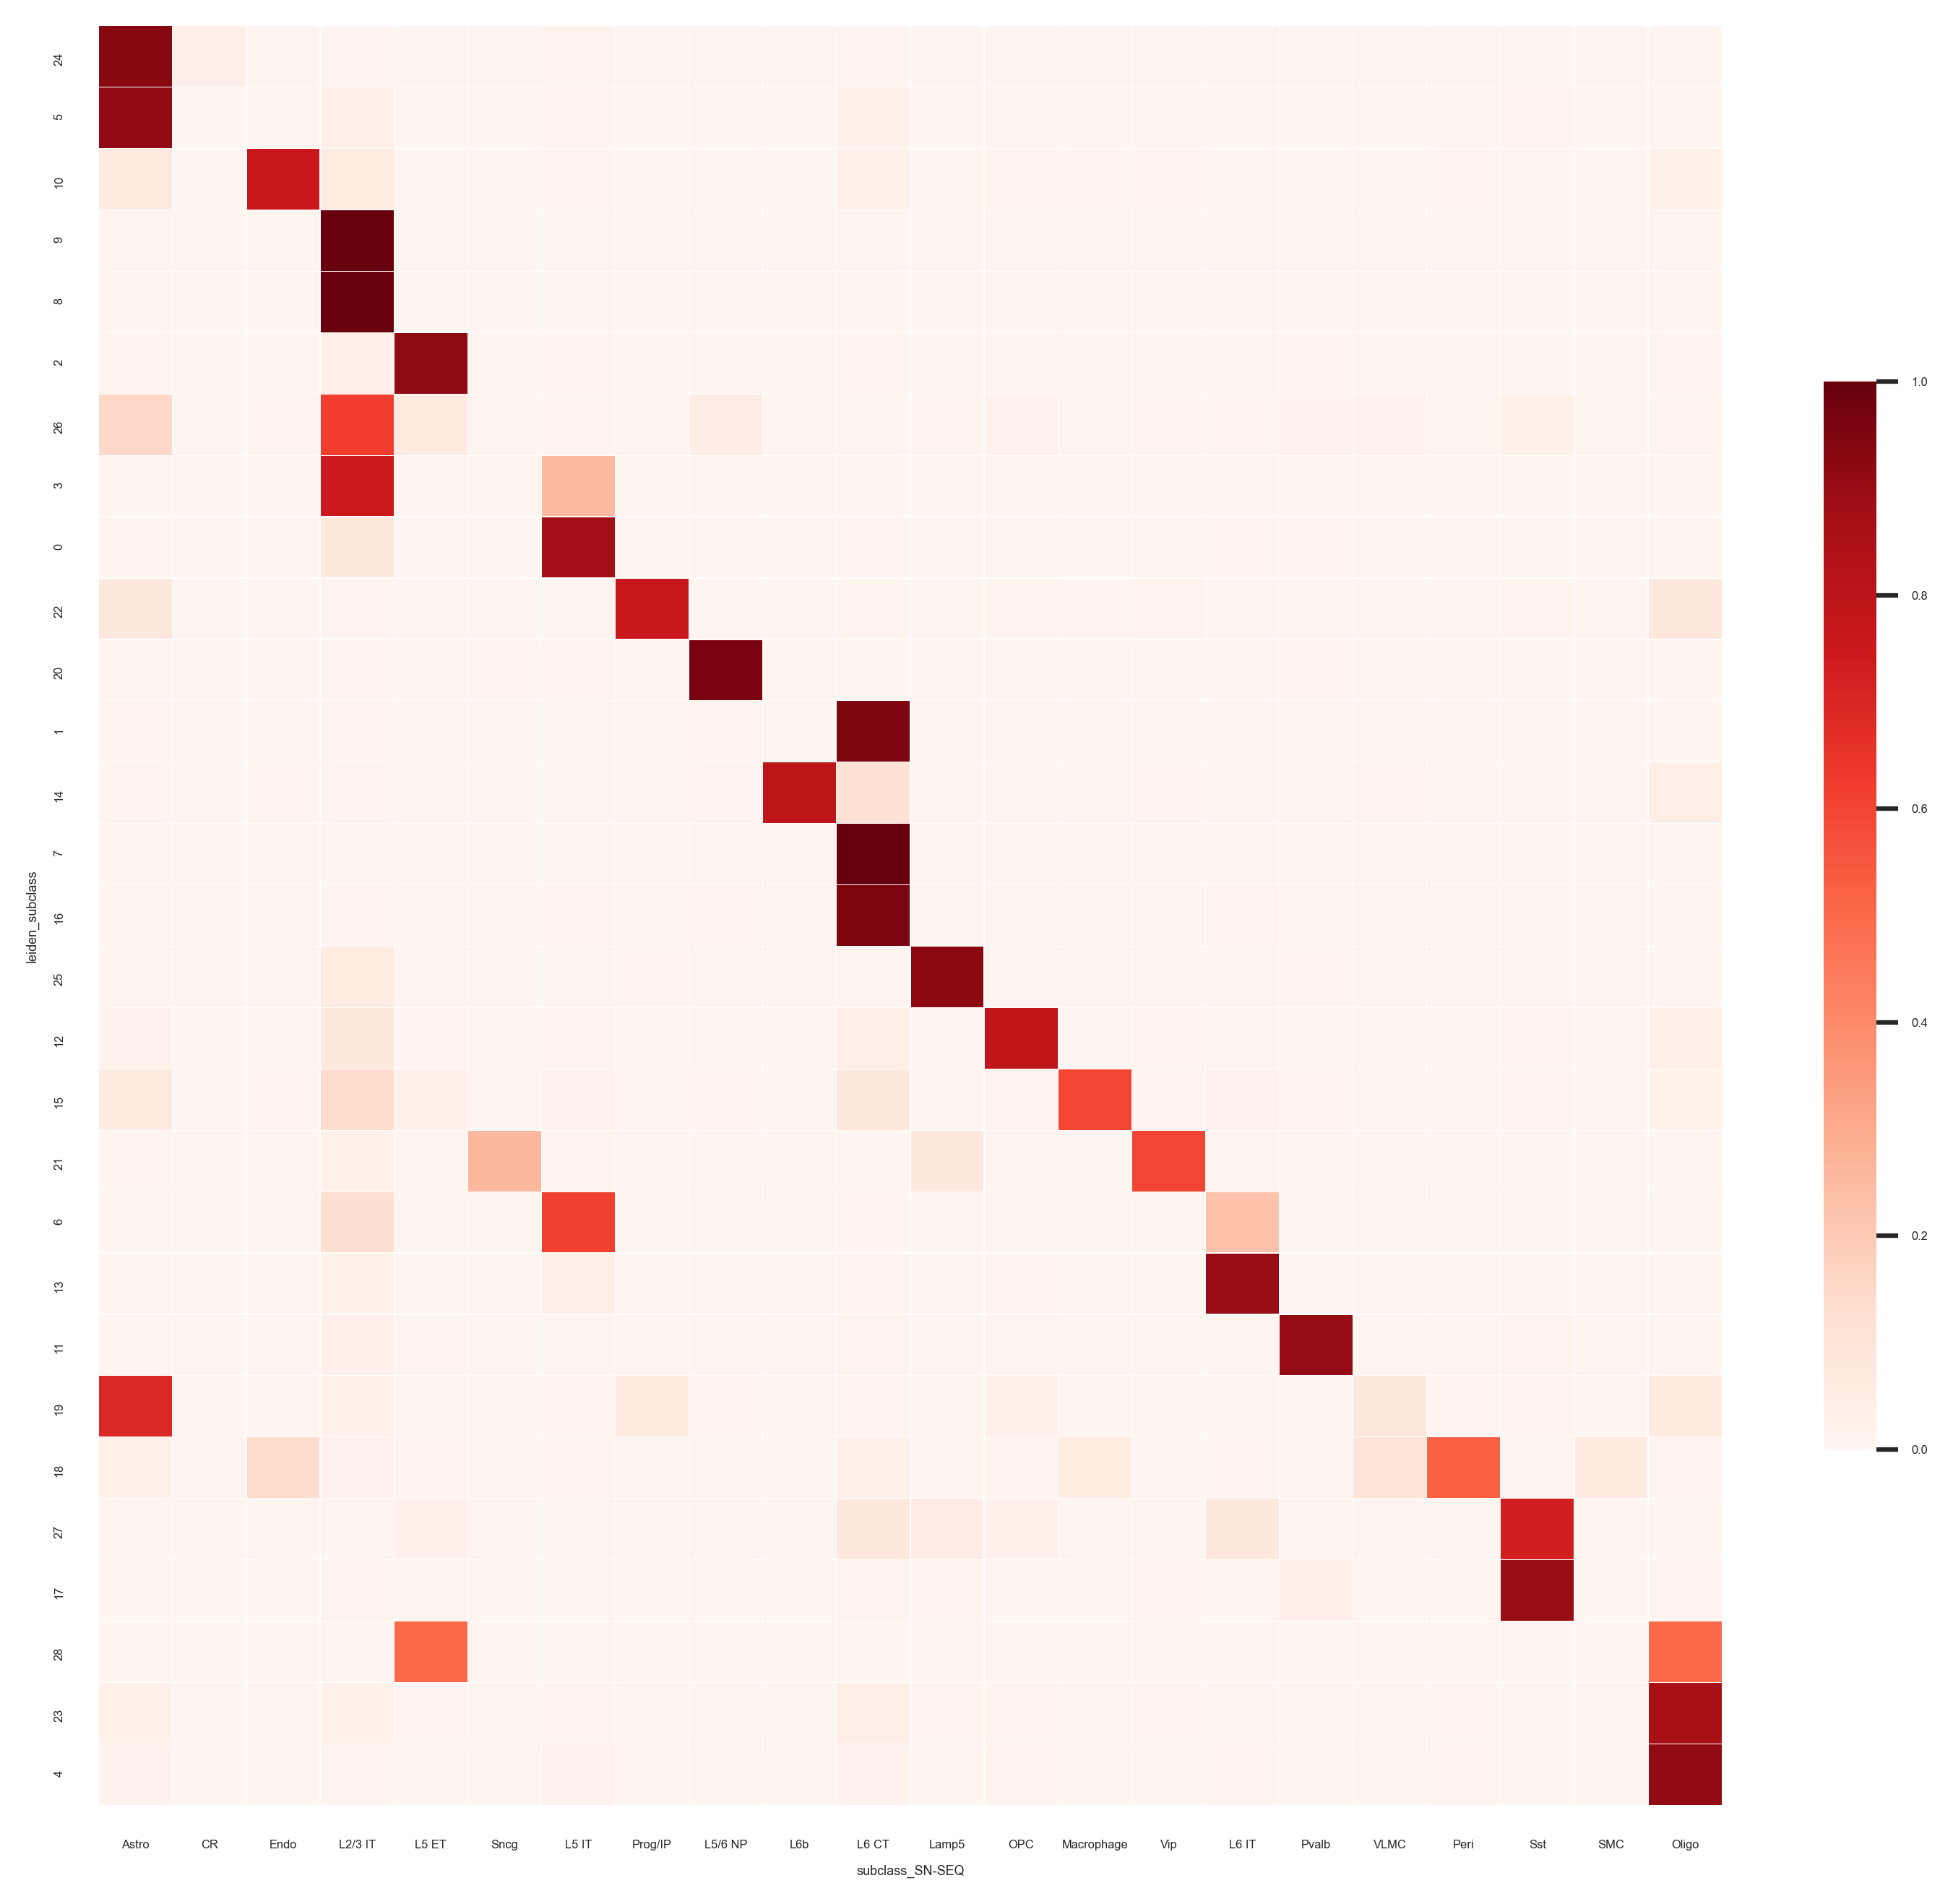

Wall time: 2min 2s


In [323]:
%%time
corr_df = plot_cluster_correspondance(adata_sn_mg, adata_mer, 'subclass_SN-SEQ', 'leiden_subclass')

In [324]:
corr_df.columns

#len(corr_df.columns)

Index(['Astro', 'CR', 'Endo', 'L2/3 IT', 'L5 ET', 'Sncg', 'L5 IT', 'Prog/IP',
       'L5/6 NP', 'L6b', 'L6 CT', 'Lamp5', 'OPC', 'Macrophage', 'Vip', 'L6 IT',
       'Pvalb', 'VLMC', 'Peri', 'Sst', 'SMC', 'Oligo'],
      dtype='object', name='predicted_classes')

In [325]:
#corr_df.index[14]

corr_df.index

CategoricalIndex(['24', '5', '10', '9', '8', '2', '26', '3', '0', '22', '20',
                  '1', '14', '7', '16', '25', '12', '15', '21', '6', '13',
                  '11', '19', '18', '27', '17', '28', '23', '4'],
                 categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, name='leiden_subclass', dtype='category')

In [326]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L5 IT',
                          'L6 IT','L5 ET','L5/6 NP','L6 CT','L6b','Prog/IP','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Macrophage','CR']



In [327]:
typed_coor_df

predicted_classes,Lamp5,Sncg,Vip,Sst,Pvalb,L2/3 IT,L5 IT,L6 IT,L5 ET,L5/6 NP,...,Prog/IP,Astro,OPC,Oligo,Endo,VLMC,SMC,Peri,Macrophage,CR
leiden_subclass,,,,,,,,,,,,,,,,,,,,,
25,0.875969,0.000000,0.015504,0.000000,0.023256,0.069767,0.000000,0.000000,0.000000,0.000000,...,0.007752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.735814,0.263256,0.000000,0.000930,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.002878,0.000000,0.001439,0.061871,0.007194,0.000000,0.000000,0.001439,...,0.001439,0.069065,0.012950,0.020144,0.779856,0.002878,0.001439,0.004317,0.002878,0.000000
9,0.001271,0.000000,0.000000,0.000000,0.000000,0.993647,0.000000,0.001271,0.000000,0.000000,...,0.001271,0.000000,0.001271,0.000000,0.000000,0.001271,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.001255,0.000000,0.001255,0.996236,0.001255,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.001658,0.000000,0.004146,0.002488,0.010779,0.023217,0.006633,0.008292,0.908789,0.001658,...,0.000829,0.011609,0.003317,0.004146,0.001658,0.000000,0.000000,0.000000,0.000829,0.001658
1,0.000000,0.000794,0.002381,0.000000,0.000000,0.010317,0.000794,0.000794,0.001587,0.014286,...,0.000794,0.003175,0.000794,0.000794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000794
7,0.000000,0.000000,0.005896,0.000000,0.000000,0.001179,0.000000,0.001179,0.000000,0.000000,...,0.000000,0.001179,0.000000,0.001179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000735,0.000000,0.000735,0.000735,0.006613,0.109478,0.849375,0.008817,0.002204,0.000735,...,0.000000,0.008082,0.002204,0.000000,0.000735,0.001470,0.000735,0.000735,0.000000,0.002939


In [328]:
#sorted_coor_df
sorted_coor_df.index

CategoricalIndex(['25', '21', '9', '27', '17', '11', '8', '3', '0', '6', '13',
                  '1', '2', '20', '16', '7', '14', '5', '12', '23', '4', '10',
                  '19', '28', '18', '15', '22', '26', '24'],
                 categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, name='leiden_subclass', dtype='category')

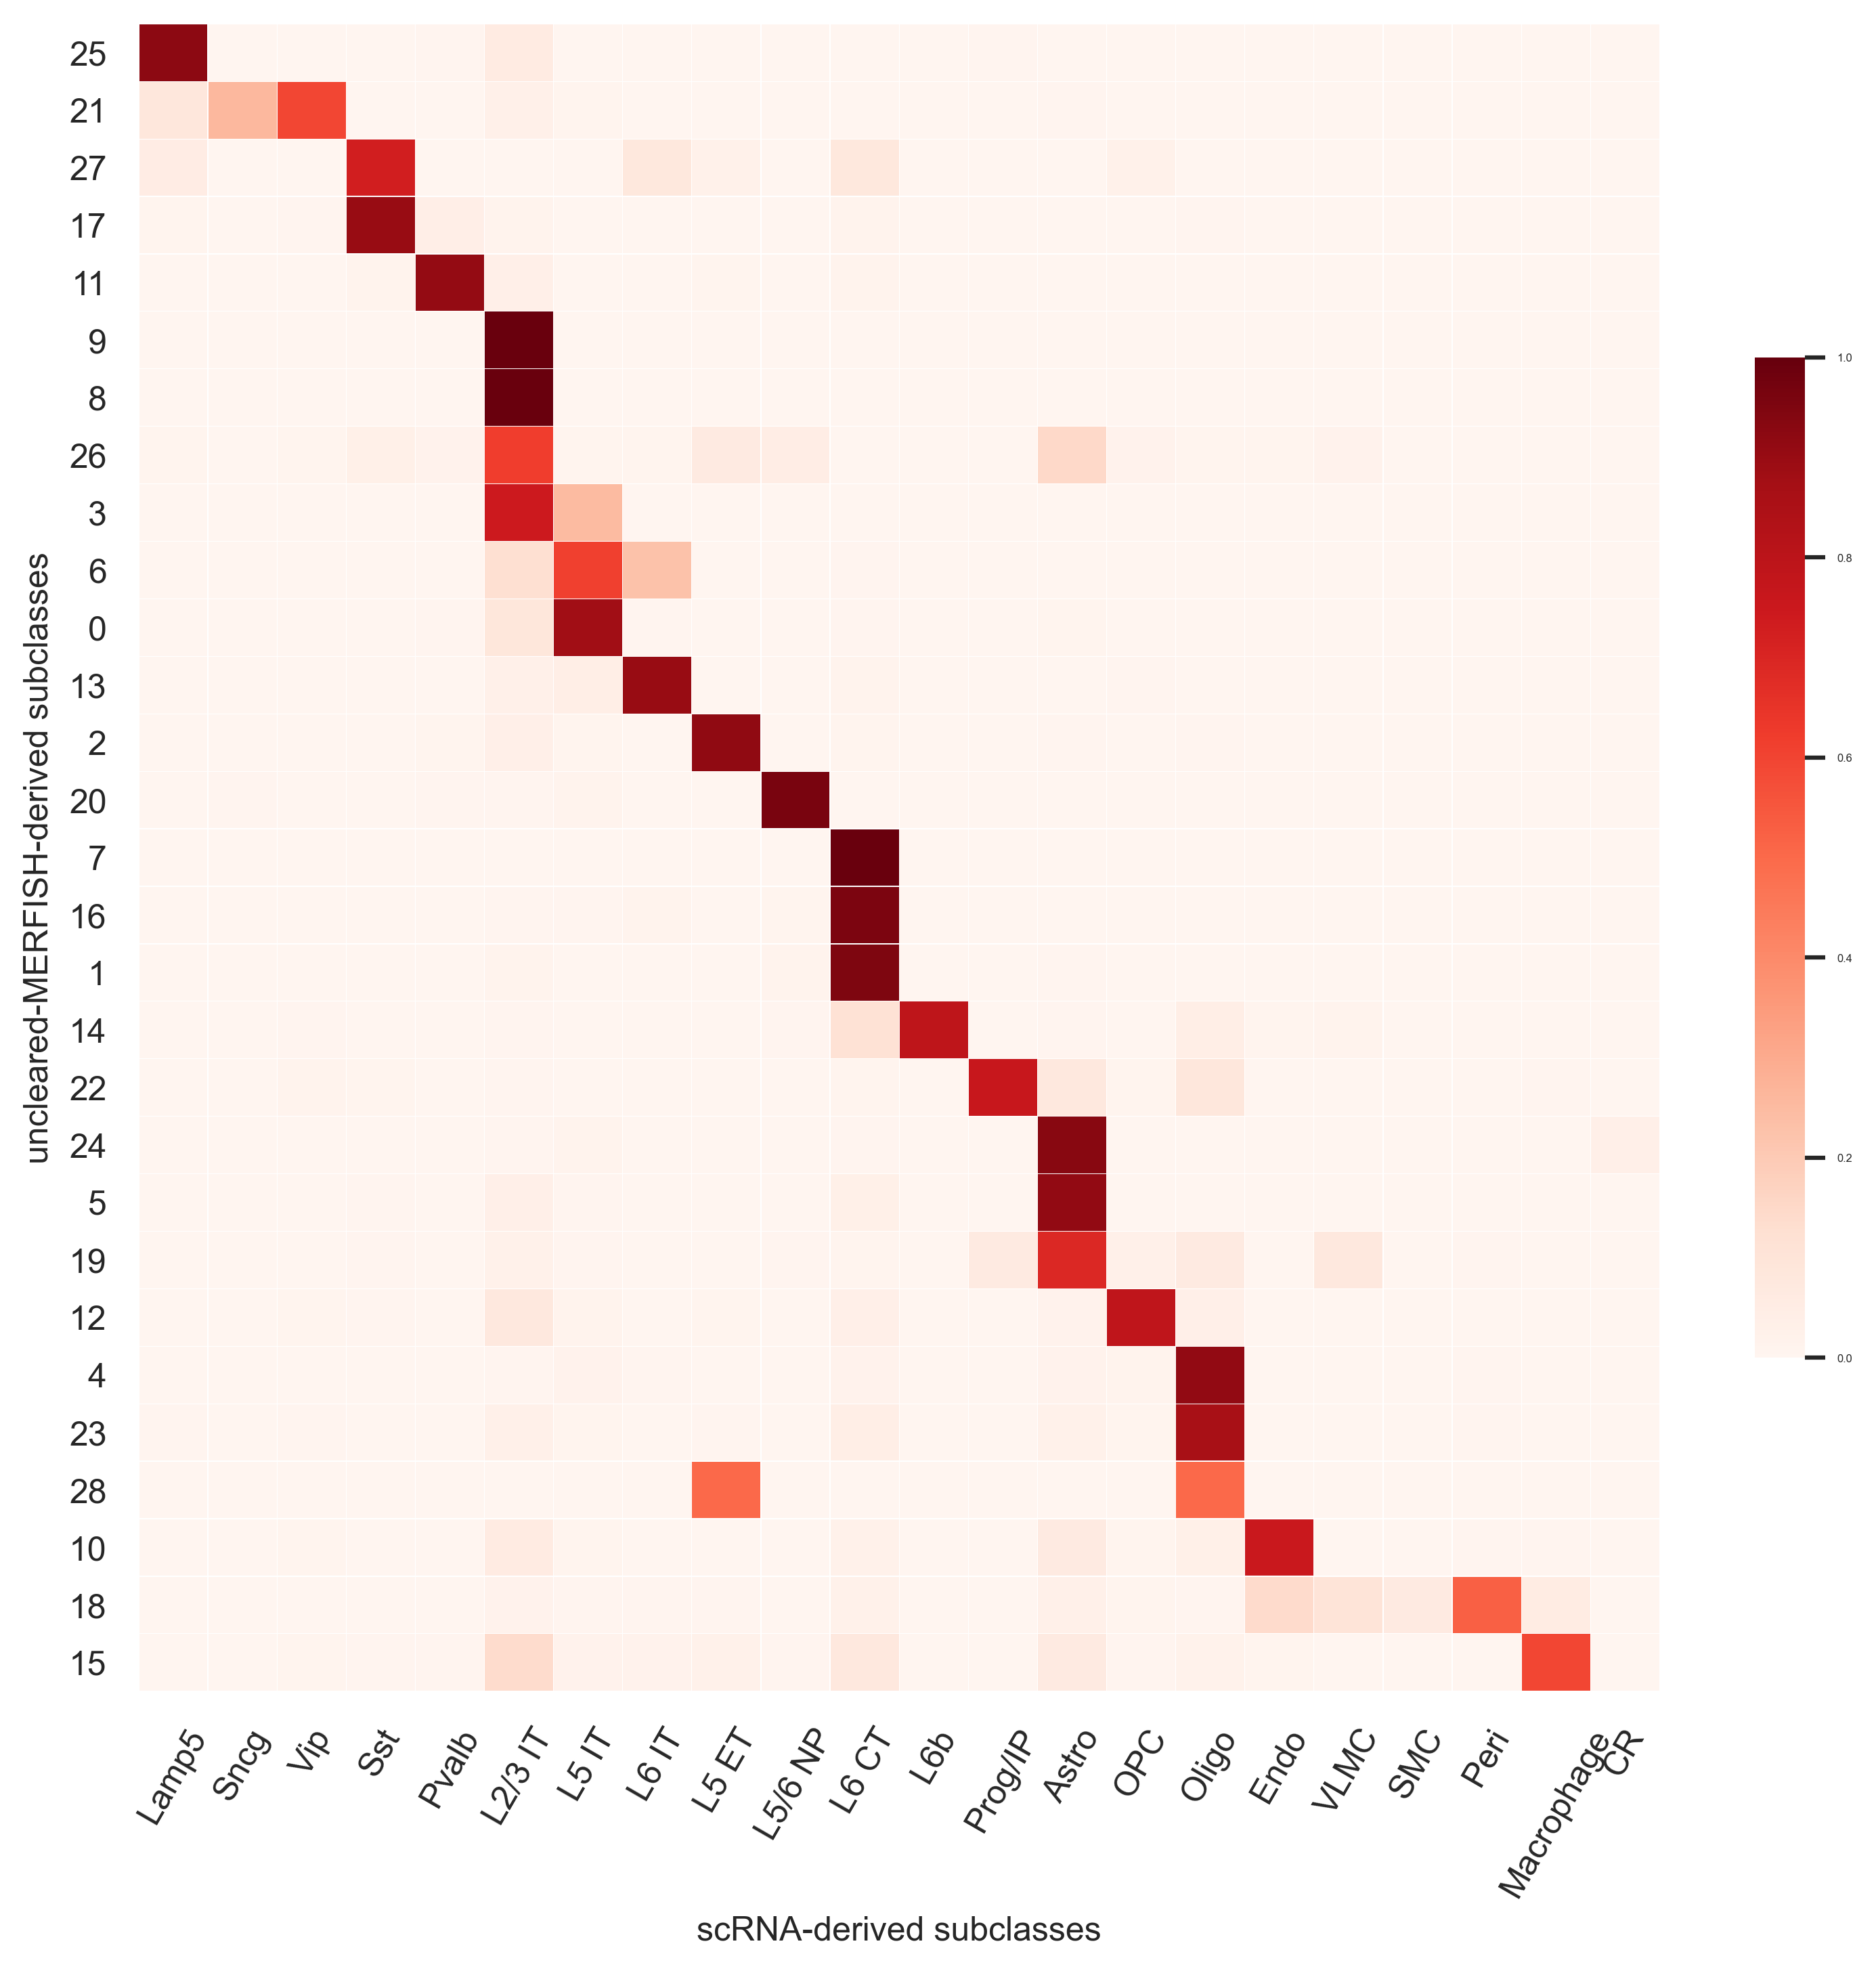

In [329]:
#corr_df

typed_coor_df = corr_df[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(typed_coor_df,'Rows',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df.reindex(['25', '21',  '27', '17', '11', '9',  '8','26', '3','6','0', '13',
                  '2', '20', '7', '16','1', '14', '22', '24', '5', '19','12', '4','23', '28', '10',
                   '18', '15'])



_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    plt.xlabel('scRNA-derived subclasses',fontsize=10)
    plt.ylabel('uncleared-MERFISH-derived subclasses',fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    plt.show()

Train a classifier using 241 genes and 148637 cells.
Predict cell types.


<ipython-input-42-534d4e2741db>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


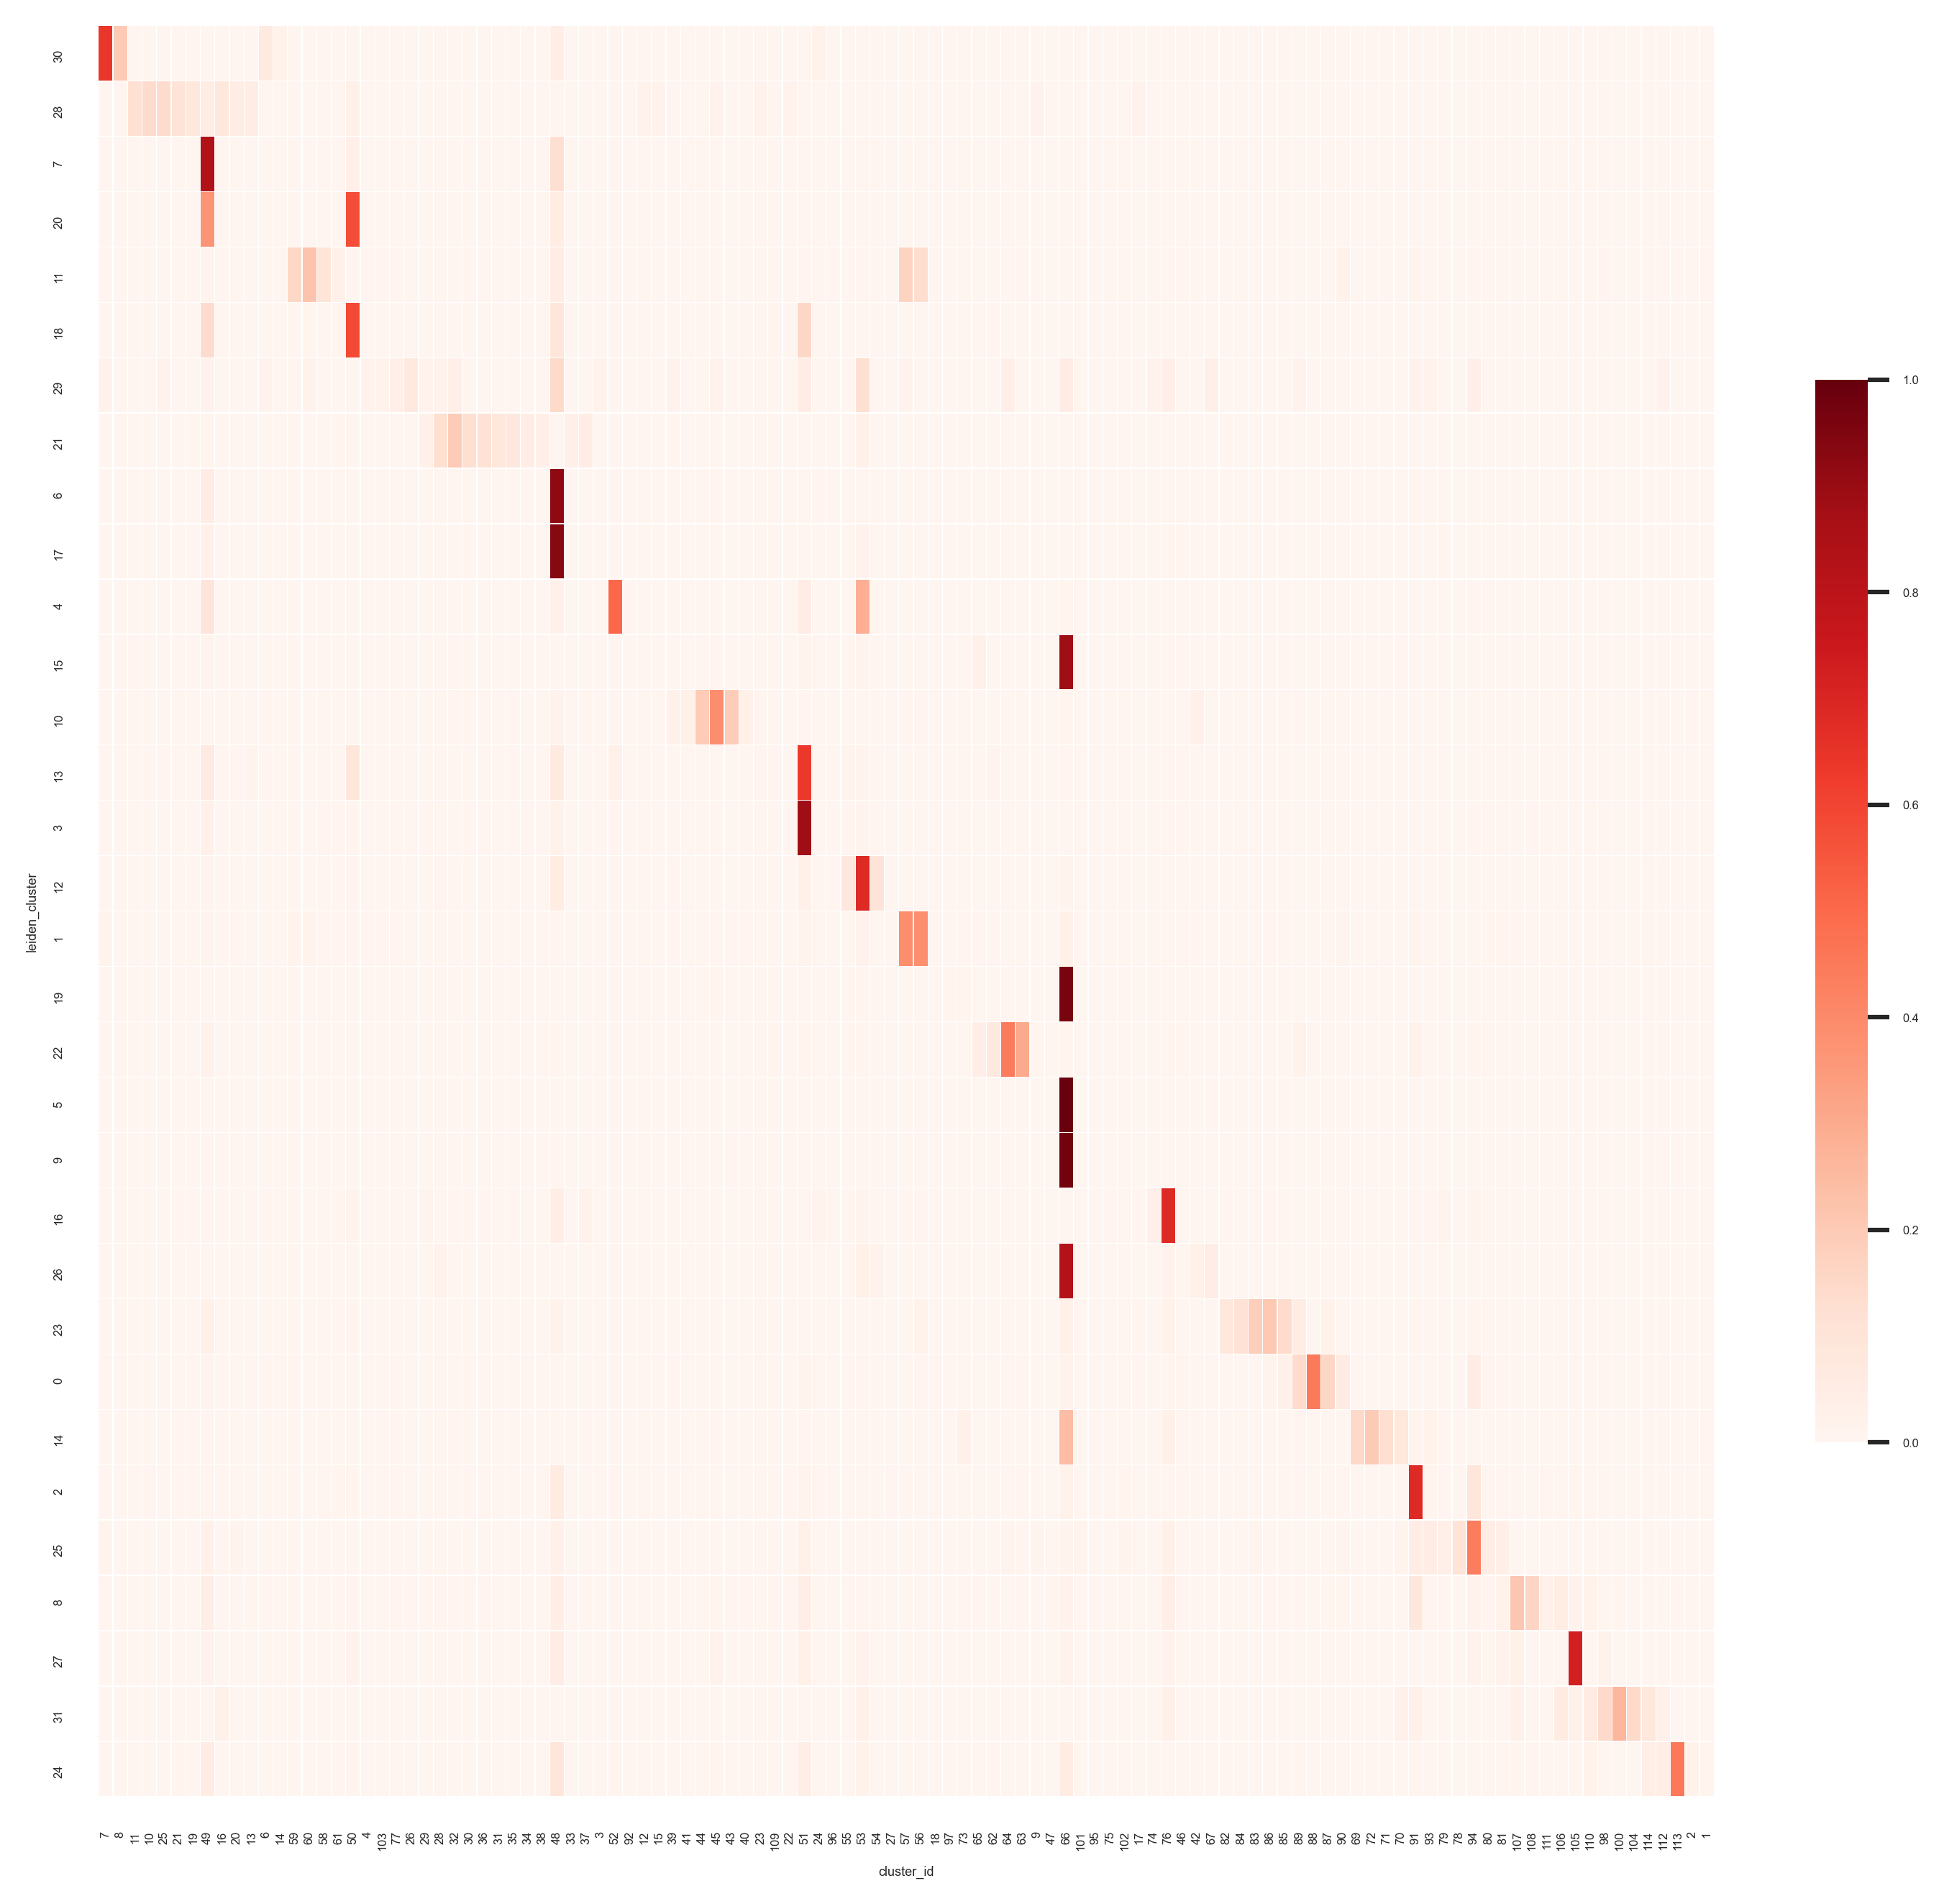

Wall time: 14min 26s


In [47]:
%%time
fractions_sorted = plot_cluster_correspondance(adata_sn_mg, adata_mer, 'cluster_id', 'leiden_cluster')

In [49]:
# Map the SN-seq clusters to the MERFISH clusters
cluster_map = {}
cluster_map_int = {}
id_max = fractions_sorted.idxmax(axis=1, skipna=True)

for i in id_max.index:
    cluster_map[str(i)] = id_max[i]
    cluster_map_int[int(i)] = id_max[i]
    
print(cluster_map)
print(cluster_map_int)

{'30': 7, '28': 10, '7': 49, '20': 50, '11': 60, '18': 50, '29': 48, '21': 32, '6': 48, '17': 48, '4': 52, '15': 66, '10': 45, '13': 51, '3': 51, '12': 53, '1': 57, '19': 66, '22': 64, '5': 66, '9': 66, '16': 76, '26': 66, '23': 86, '0': 88, '14': 66, '2': 91, '25': 94, '8': 107, '27': 105, '31': 100, '24': 113}
{30: 7, 28: 10, 7: 49, 20: 50, 11: 60, 18: 50, 29: 48, 21: 32, 6: 48, 17: 48, 4: 52, 15: 66, 10: 45, 13: 51, 3: 51, 12: 53, 1: 57, 19: 66, 22: 64, 5: 66, 9: 66, 16: 76, 26: 66, 23: 86, 0: 88, 14: 66, 2: 91, 25: 94, 8: 107, 27: 105, 31: 100, 24: 113}


In [33]:
print([i for i in list(fractions_sorted.columns) if i[0] == 'L' and i[1] != 'a'])

['L45_IT_3', 'L23_IT_2', 'L23_IT_3', 'L45_IT_2', 'L45_IT_4', 'L5_IT_1', 'L5_IT_4', 'L6_IT_1', 'L6_IT_3', 'L6_IT_2', 'L5_ET_5', 'L5_IT_3', 'L5_ET_1', 'L5_ET_2', 'L5_ET_3', 'L5_ET_4', 'L56_NP_1', 'L56_NP_2', 'L6_CT_4', 'L6_CT_1', 'L6_CT_3', 'L6_CT_2', 'L6b_2', 'L6b_1', 'L45_IT_5', 'L6b_3', 'L23_IT_4', 'L23_IT_1', 'L6_CT_5', 'L45_IT_1', 'L5_IT_2', 'L6_CT_6', 'L45_IT_SSp_2', 'L45_IT_SSp_1', 'L6_CT_7', 'L23_IT_5', 'L6_CT_8', 'L6_IT_Car3', 'L6_CT_9']


# Use MERFISH from MENG to classify

In [216]:

adata_mer = adata_mer

MOp_MERFISH_meng_preprocessed_for_integration_file =r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer/counts.h5ad'

merfish_raw = sc.read_h5ad(MOp_MERFISH_meng_preprocessed_for_integration_file)

In [217]:
adata_mer.var

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mean,std
1700022I11Rik,801,0.021943,97.939497,853.0,-1.097337e-11,0.066552
1810046K07Rik,655,0.017467,98.315069,679.0,-1.648834e-11,0.054253
5031425F14Rik,860,0.023666,97.787724,920.0,2.336084e-11,0.065691
5730522E02Rik,472,0.012759,98.785821,496.0,-4.270565e-12,0.049682
Acta2,2778,0.140299,92.853835,5454.0,-1.695216e-10,0.237731
...,...,...,...,...,...,...
Vtn,1401,0.323995,96.396049,12595.0,8.487571e-11,0.382078
Vwc2,2007,0.108479,94.837166,4217.0,-5.875098e-11,0.145772
Wipf3,13334,3.868807,65.699439,150396.0,-2.418187e-09,0.798553
Wnt7b,7307,0.600916,81.203375,23360.0,-3.890969e-11,0.409263


In [218]:
adata_mer.obs

,fov,volume,center_x,center_y,min_x,max_x,min_y,max_y,n_genes_by_counts,total_counts,leiden,leiden_cluster,leiden_subclass
Unnamed: 0,,,,,,,,,,,,,
103330822042850904545146152121560032943,0,500.261521,-3522.831946,-472.727995,-3528.890746,-3516.773146,-478.138795,-467.317195,41,100.0,23,22,23
104063594401945690395360274842267295495,0,1864.496795,-3689.745950,-595.685998,-3697.154751,-3682.337150,-604.174798,-587.197198,108,788.0,1,18,1
104258342410009895929559247312985567503,0,1570.087389,-3555.879947,-620.687999,-3564.098747,-3547.661147,-629.662799,-611.713198,131,801.0,21,31,21
104918479368639330347571169891166551407,0,1906.891355,-3643.143949,-528.239996,-3652.766749,-3633.521149,-535.918796,-520.561196,100,810.0,2,3,2
107930258087179212316276640499012396013,0,1155.292899,-3553.557947,-518.681996,-3560.642747,-3546.473147,-526.090796,-511.273196,96,493.0,16,18,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62404979957498828768934697084130207956,158,1391.703996,3679.310099,-5.315999,3666.933298,3691.686899,-11.914799,1.282801,52,206.0,22,24,22
63726610533314430357332892254603092389,158,749.266122,3728.666100,96.528004,3722.445300,3734.886900,90.577203,102.478804,50,140.0,24,35,24
71463130736397350506214027498827904691,158,1388.946393,3733.310100,107.274004,3725.469300,3741.150900,100.081204,114.466804,58,219.0,24,35,24


In [207]:
merfish_label = pd.read_csv(r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer/cell_labels.csv', index_col=0)

In [208]:
merData = pd.DataFrame(merfish_raw.X, index = merfish_raw.obs.index, columns = merfish_raw.var.index)
labels = merfish_label.loc[merfish_label['label']!='-1']
merData

index,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Gad2,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.659448,0.000000,...,0.261892,0.262109,0.037601,0.010633,0.192950,0.079685,0.063194,0.613834,0.038716,0.000000
100001798412490480358118871918100400402,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.512115,0.225832,0.093828,0.000000,0.160687,0.171461,0.208027,0.618113,0.051407,0.000000
100006878605830627922364612565348097824,0.0,0.000000,0.0,0.000000,25.567039,0.0,0.000000,0.000000,0.000000,0.000000,...,0.199059,0.114653,0.000000,0.070231,0.144294,0.051351,0.148232,0.448829,0.041903,0.000000
100007228202835962319771548915451072492,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.240500,0.093413,0.033100,0.151837,0.197471,0.011399,0.110675,1.117577,0.016462,0.467554
100009332472089331948140672873134747603,0.0,0.491629,0.0,0.983257,0.491629,0.0,0.000000,0.000000,0.983257,0.000000,...,1.726676,0.533404,3.691514,0.000000,0.296567,0.748264,1.423427,11.386119,0.387408,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,0.0,0.000000,0.0,0.557620,0.000000,0.0,0.000000,0.000000,0.557620,2.788098,...,4.711612,1.145445,0.000000,0.362137,1.549598,0.195306,4.132728,1.586415,0.152228,8.515803
99989592830367590092304100078674096866,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.829112,14.632893,0.000000,...,0.354238,0.160562,0.630489,0.030634,0.073509,0.000000,0.210928,4.954309,0.140572,0.107833
99991756591196613545069880666241120777,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.944207,0.221704,0.139209,0.854429,0.296027,0.110999,0.432686,5.654802,0.042431,0.004518


In [209]:
labels

,sample_id,slice_id,class_label,subclass,label
10000143038275111136124942858811168393,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1
100001798412490480358118871918100400402,mouse2_sample5,mouse2_slice160,Other,Endo,Endo
100006878605830627922364612565348097824,mouse2_sample6,mouse2_slice109,Other,SMC,SMC
100007228202835962319771548915451072492,mouse1_sample2,mouse1_slice71,Other,Endo,Endo
100009332472089331948140672873134747603,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3
...,...,...,...,...,...
99987465505639073211021560543065098772,mouse1_sample5,mouse1_slice251,GABAergic,Pvalb,Pvalb_1
99989592830367590092304100078674096866,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_5
99991756591196613545069880666241120777,mouse1_sample3,mouse1_slice112,Glutamatergic,L4/5 IT,L45_IT_3
99997421766159526763299676887100858104,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_3


In [235]:
merCluster=merData.merge(labels, how='inner', left_index=True, right_index=True)
merCluster.shape

merCluster

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Sst,Rab3b,Slc17a7,Penk,Gad1,sample_id,slice_id,class_label,subclass,label
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.659448,0.000000,...,0.079685,0.063194,0.613834,0.038716,0.000000,mouse2_sample4,mouse2_slice31,Other,Astro,Astro_1
100001798412490480358118871918100400402,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.171461,0.208027,0.618113,0.051407,0.000000,mouse2_sample5,mouse2_slice160,Other,Endo,Endo
100006878605830627922364612565348097824,0.0,0.000000,0.0,0.000000,25.567039,0.0,0.000000,0.000000,0.000000,0.000000,...,0.051351,0.148232,0.448829,0.041903,0.000000,mouse2_sample6,mouse2_slice109,Other,SMC,SMC
100007228202835962319771548915451072492,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.011399,0.110675,1.117577,0.016462,0.467554,mouse1_sample2,mouse1_slice71,Other,Endo,Endo
100009332472089331948140672873134747603,0.0,0.491629,0.0,0.983257,0.491629,0.0,0.000000,0.000000,0.983257,0.000000,...,0.748264,1.423427,11.386119,0.387408,0.000000,mouse2_sample5,mouse2_slice219,Glutamatergic,L2/3 IT,L23_IT_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,0.0,0.000000,0.0,0.557620,0.000000,0.0,0.000000,0.000000,0.557620,2.788098,...,0.195306,4.132728,1.586415,0.152228,8.515803,mouse1_sample5,mouse1_slice251,GABAergic,Pvalb,Pvalb_1
99989592830367590092304100078674096866,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.829112,14.632893,0.000000,...,0.000000,0.210928,4.954309,0.140572,0.107833,mouse2_sample3,mouse2_slice261,Glutamatergic,L5 ET,L5_ET_5
99991756591196613545069880666241120777,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.110999,0.432686,5.654802,0.042431,0.004518,mouse1_sample3,mouse1_slice112,Glutamatergic,L4/5 IT,L45_IT_3


In [239]:
merCluster.iloc[:,:-5]

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Gad2,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.659448,0.000000,...,0.261892,0.262109,0.037601,0.010633,0.192950,0.079685,0.063194,0.613834,0.038716,0.000000
100001798412490480358118871918100400402,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.512115,0.225832,0.093828,0.000000,0.160687,0.171461,0.208027,0.618113,0.051407,0.000000
100006878605830627922364612565348097824,0.0,0.000000,0.0,0.000000,25.567039,0.0,0.000000,0.000000,0.000000,0.000000,...,0.199059,0.114653,0.000000,0.070231,0.144294,0.051351,0.148232,0.448829,0.041903,0.000000
100007228202835962319771548915451072492,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.240500,0.093413,0.033100,0.151837,0.197471,0.011399,0.110675,1.117577,0.016462,0.467554
100009332472089331948140672873134747603,0.0,0.491629,0.0,0.983257,0.491629,0.0,0.000000,0.000000,0.983257,0.000000,...,1.726676,0.533404,3.691514,0.000000,0.296567,0.748264,1.423427,11.386119,0.387408,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,0.0,0.000000,0.0,0.557620,0.000000,0.0,0.000000,0.000000,0.557620,2.788098,...,4.711612,1.145445,0.000000,0.362137,1.549598,0.195306,4.132728,1.586415,0.152228,8.515803
99989592830367590092304100078674096866,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.829112,14.632893,0.000000,...,0.354238,0.160562,0.630489,0.030634,0.073509,0.000000,0.210928,4.954309,0.140572,0.107833
99991756591196613545069880666241120777,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.944207,0.221704,0.139209,0.854429,0.296027,0.110999,0.432686,5.654802,0.042431,0.004518


In [242]:
merGroupedDataZ = pd.DataFrame(preprocessing.scale(merCluster.iloc[:,:-5]),index = merCluster.iloc[:,:-5].index, columns = merCluster.iloc[:,:-5].columns)

merGroupedDataZ['subclass'] = merCluster.iloc[:,-2]

C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\shiwei\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [243]:
merGroupedDataZ

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Tac2,Lamp5,Cnr1,Pvalb,Sst,Rab3b,Slc17a7,Penk,Gad1,subclass
index,,,,,,,,,,,,,,,,,,,,,
10000143038275111136124942858811168393,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.348175,-0.274825,...,-0.384528,-0.483580,-0.246400,-0.346832,-0.126652,-0.780719,-0.971601,-0.381083,-0.245849,Astro
100001798412490480358118871918100400402,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.481826,-0.447294,-0.255495,-0.383033,-0.095295,-0.624110,-0.970920,-0.364425,-0.245849,Endo
100006878605830627922364612565348097824,-0.14432,-0.270846,-0.161999,-0.222231,5.728458,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.780022,-0.507845,-0.195420,-0.401427,-0.136333,-0.688766,-0.997852,-0.376900,-0.245849,SMC
100007228202835962319771548915451072492,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.836989,-0.486484,-0.125615,-0.341760,-0.149984,-0.729377,-0.891460,-0.410295,-0.111492,Endo
100009332472089331948140672873134747603,-0.14432,1.116969,-0.161999,3.536333,-0.110647,-0.215885,-0.305883,-0.257521,-0.264185,-0.274825,...,0.343120,1.874451,-0.255495,-0.230569,0.101786,0.690105,0.742187,0.076623,-0.245849,L2/3 IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,-0.14432,-0.270846,-0.161999,1.909306,-0.225128,-0.215885,-0.305883,-0.257521,-0.374588,1.675924,...,1.984689,-0.507845,0.054276,1.175393,-0.087147,3.619679,-0.816871,-0.232083,2.201252,Pvalb
99989592830367590092304100078674096866,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,0.092527,3.276286,-0.274825,...,-0.656887,-0.100963,-0.229291,-0.480851,-0.153879,-0.620974,-0.281065,-0.247383,-0.214862,L5 ET
99991756591196613545069880666241120777,-0.14432,-0.270846,-0.161999,-0.222231,-0.225128,-0.215885,-0.305883,-0.257521,-0.519224,-0.274825,...,-0.492898,-0.418007,0.475379,-0.231175,-0.115953,-0.381186,-0.169621,-0.376207,-0.244550,L4/5 IT


In [251]:
adata_ref = merGroupedDataZ
adata_ref.iloc[:,:-1]

adata_ref['subclass']

index
10000143038275111136124942858811168393       Astro
100001798412490480358118871918100400402       Endo
100006878605830627922364612565348097824        SMC
100007228202835962319771548915451072492       Endo
100009332472089331948140672873134747603    L2/3 IT
                                            ...   
99987465505639073211021560543065098772       Pvalb
99989592830367590092304100078674096866       L5 ET
99991756591196613545069880666241120777     L4/5 IT
99997421766159526763299676887100858104       L5 ET
99997470167777465101376150817407669505     L2/3 IT
Name: subclass, Length: 280186, dtype: object

In [259]:
adata_mer.X.shape

(16465, 242)

In [260]:
np.array(adata_ref.iloc[:,:-1])

array([[-0.14431989, -0.27084574, -0.16199893, ..., -0.97160107,
        -0.38108274, -0.24584861],
       [-0.14431989, -0.27084574, -0.16199893, ..., -0.9709204 ,
        -0.36442488, -0.24584861],
       [-0.14431989, -0.27084574, -0.16199893, ..., -0.99785215,
        -0.3768997 , -0.24584861],
       ...,
       [-0.14431989, -0.27084574, -0.16199893, ..., -0.16962148,
        -0.37620708, -0.2445504 ],
       [-0.14431989, -0.27084574, -0.16199893, ...,  0.7759137 ,
        -0.06533346, -0.22513984],
       [-0.14431989,  1.0701033 , -0.16199893, ...,  1.193518  ,
        -0.01472572,  0.06778419]], dtype=float32)

In [261]:
adata_query = adata_mer

genes_from_ref = set(merData.columns)
genes = list(genes_from_ref.intersection(set(adata_query.var.index)))


# Train a classifier
gene_ids = [merData.columns.get_loc(g) for g in genes]

print('Train cell type classifier.')

X = np.array(adata_ref.iloc[:,:-1])[:, gene_ids]
Y = np.array(adata_ref['subclass'])
nnc = MLPClassifier(max_iter = 500)
nnc.fit(X, Y)



MLPClassifier(max_iter=500)

Predict cell types.


<ipython-input-308-1eaf7032a0a7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


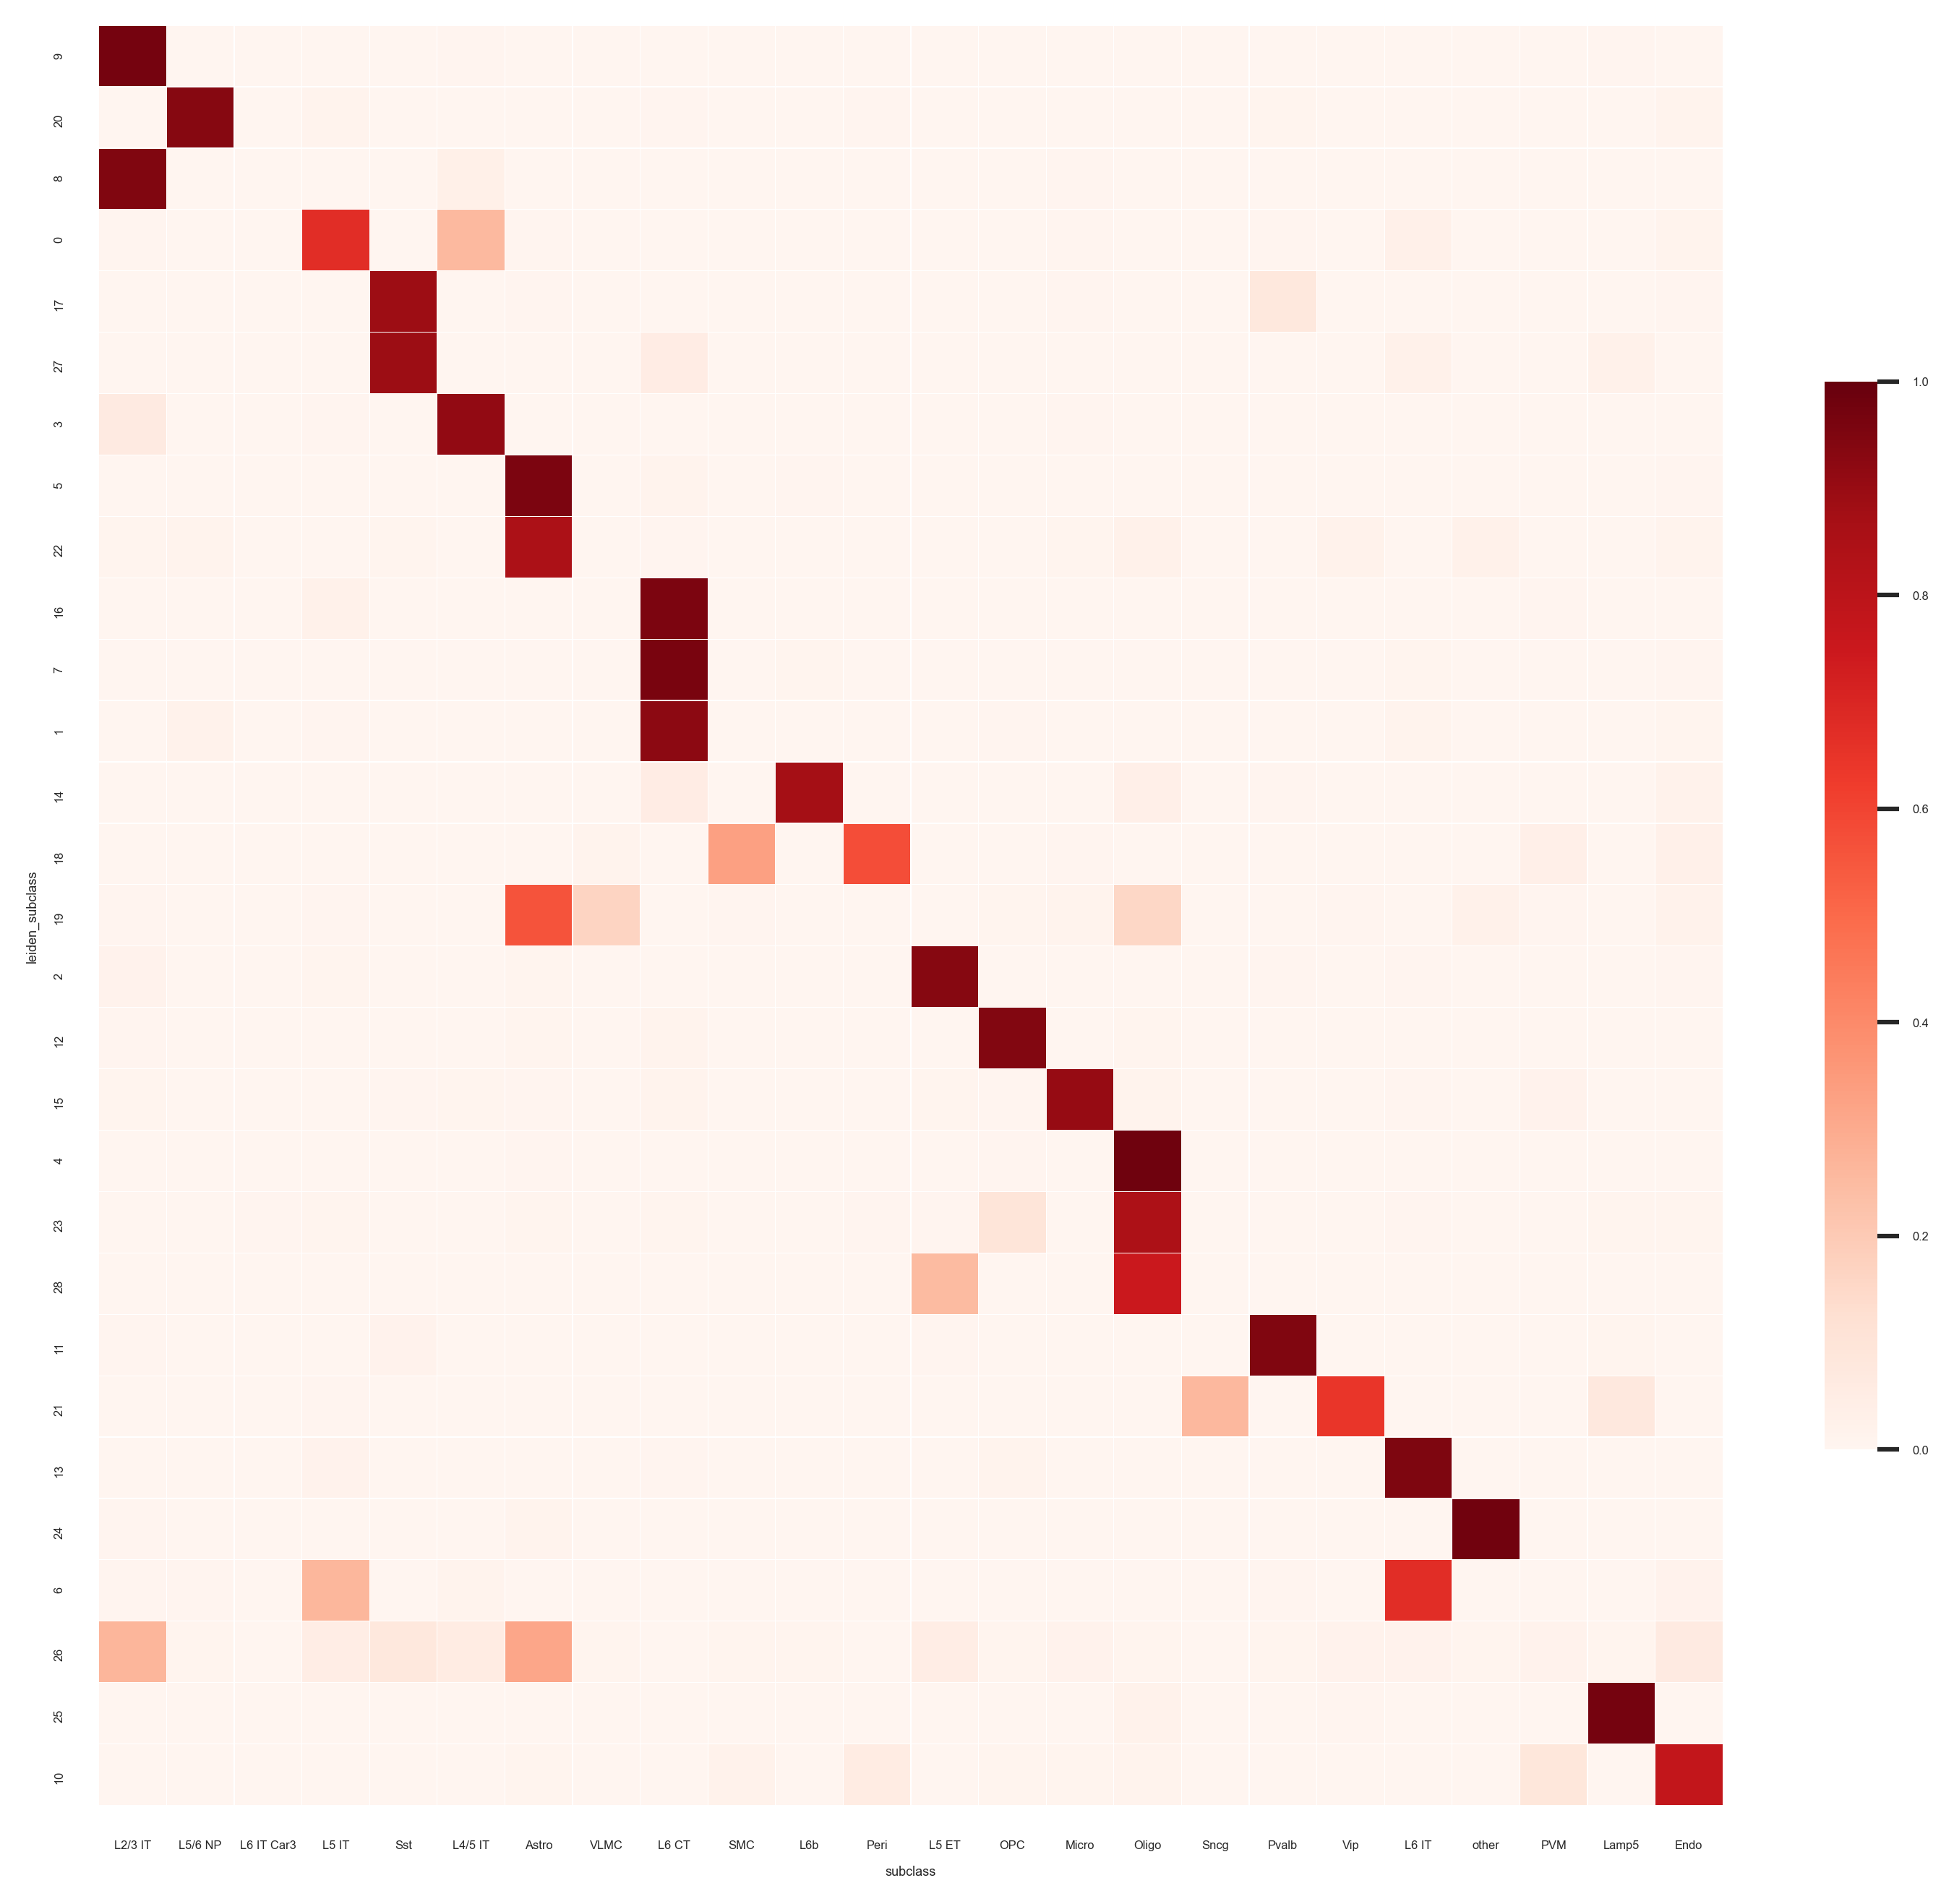

In [308]:
prediction_column = 'ref_cluster_column'

ref_cluster_column = 'subclass'

query_cluster_column = 'leiden_subclass'



print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.show()

In [341]:
nnc

MLPClassifier(max_iter=500)

In [346]:
adata_query.obs['ref_cluster_column']

Unnamed: 0
103330822042850904545146152121560032943    L5 ET
104063594401945690395360274842267295495    L6 CT
104258342410009895929559247312985567503      Vip
104918479368639330347571169891166551407    L5 ET
107930258087179212316276640499012396013    L6 CT
                                           ...  
62404979957498828768934697084130207956     Astro
63726610533314430357332892254603092389     other
71463130736397350506214027498827904691     other
84488377012712053662454730075346329945     Oligo
90200713300164731928049160856257562345     Oligo
Name: ref_cluster_column, Length: 16465, dtype: object

In [348]:
_score = nnc.score(X=adata_query.X, y=adata_query.obs['ref_cluster_column'])
_score

0.06893410264196781

In [309]:
np.unique(adata_ref['subclass'])

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype=object)

In [310]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L6 IT Car3','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','PVM','other']

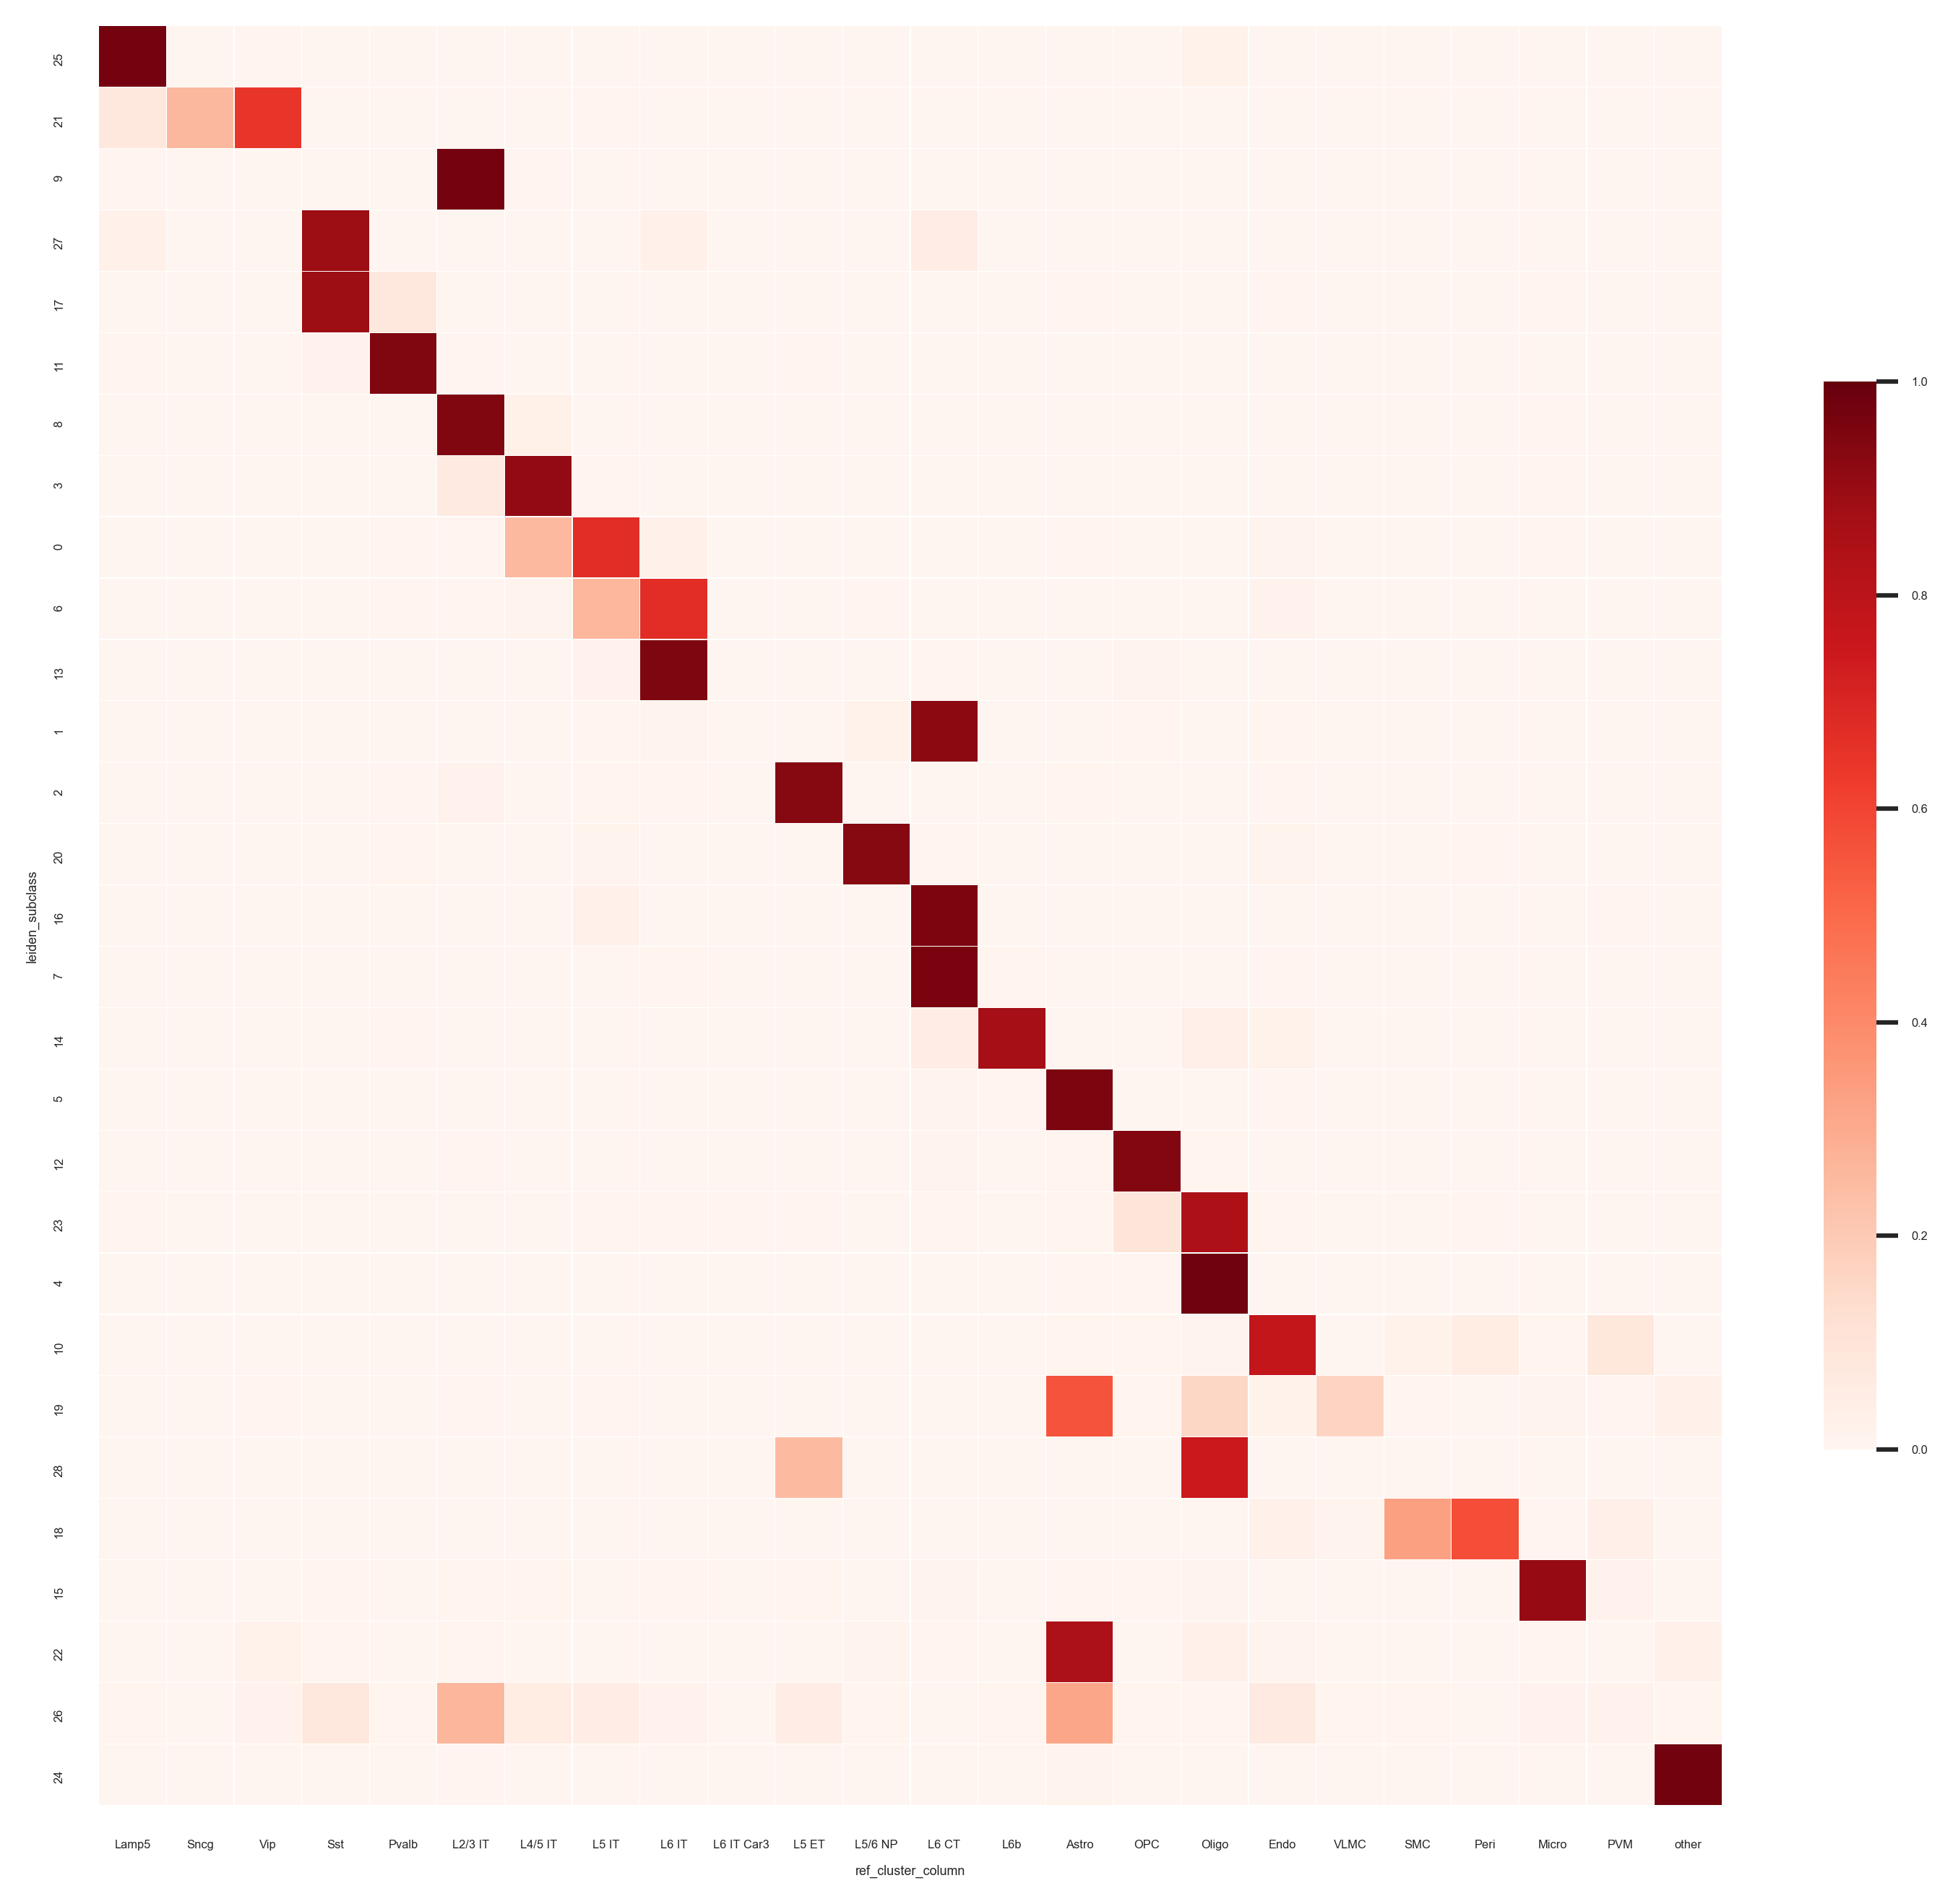

In [311]:

fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.show()

In [312]:
sorted_coor_df.index

CategoricalIndex(['25', '21', '9', '27', '17', '11', '8', '3', '0', '6', '13',
                  '1', '2', '20', '16', '7', '14', '5', '12', '23', '4', '10',
                  '19', '28', '18', '15', '22', '26', '24'],
                 categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, name='leiden_subclass', dtype='category')

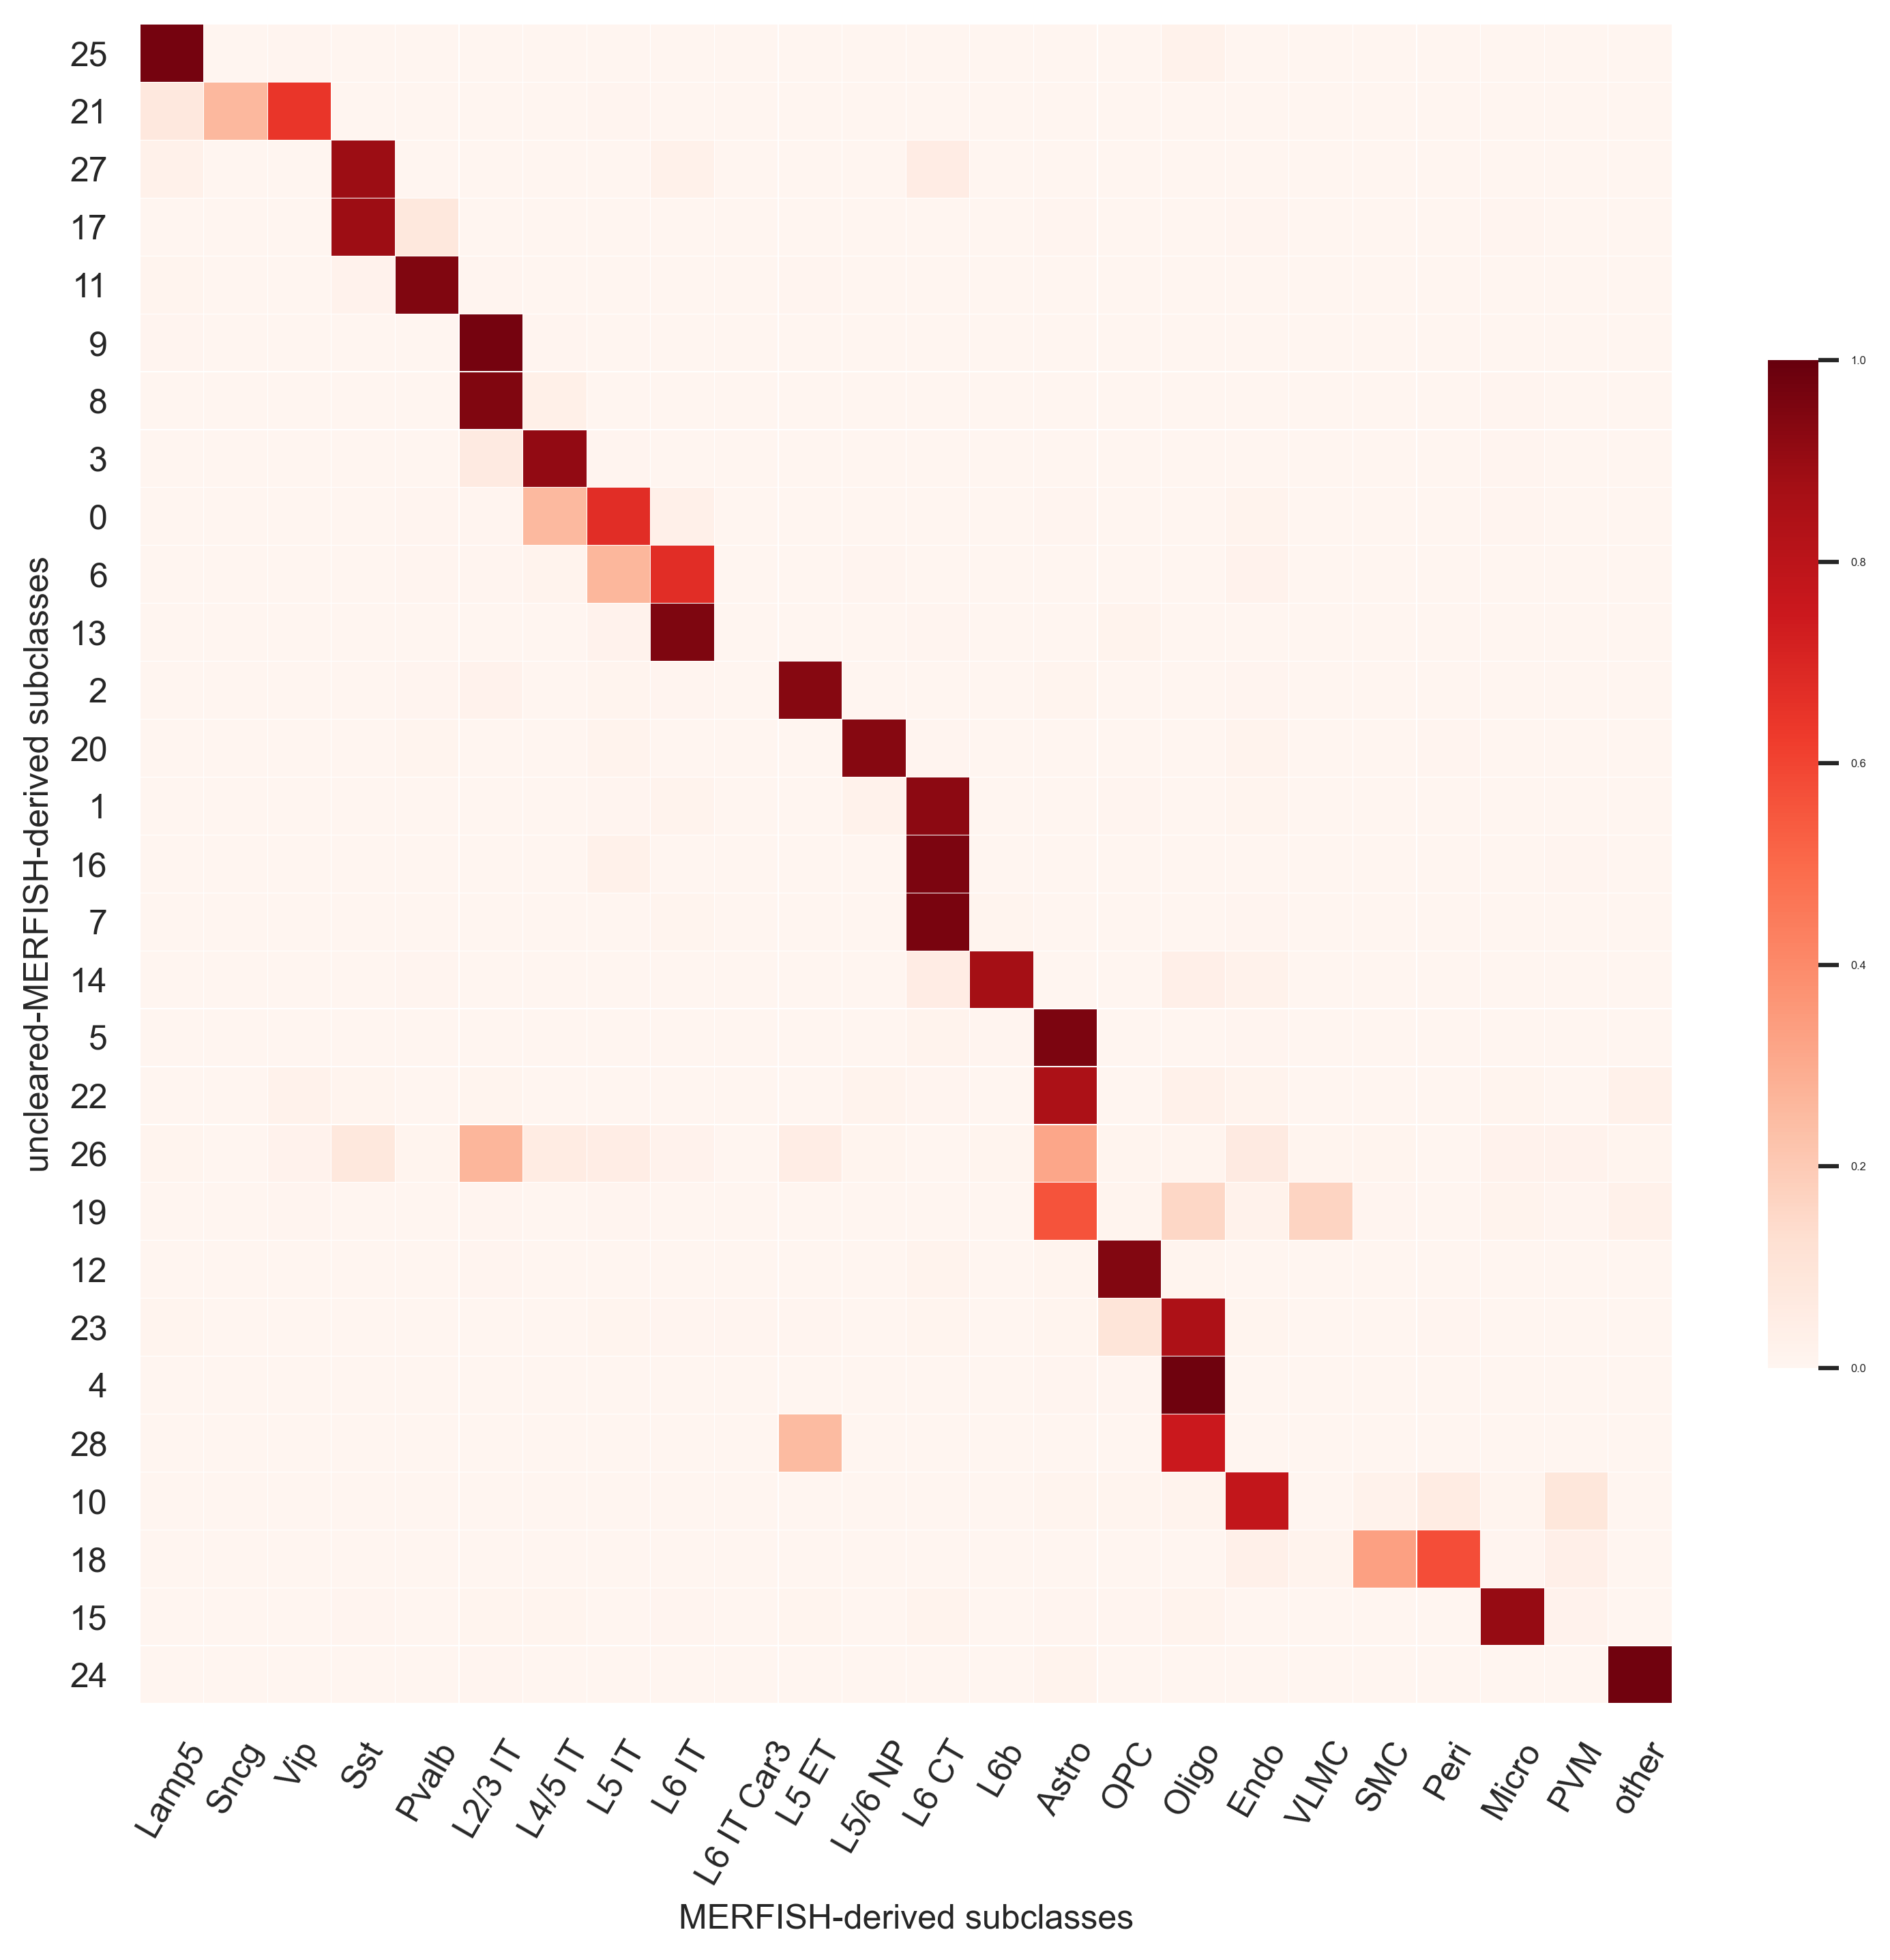

In [314]:
manual_coor_df = sorted_coor_df.reindex(['25', '21', '27', '17', '11','9',  '8', '3', '0', '6', '13',
                   '2', '20', '1','16', '7', '14', '5','22','26','19',  '12', '23', '4','28', '10',
                    '18', '15',  '24'])


if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel('MERFISH-derived subclasses',fontsize=10)
    plt.ylabel('uncleared-MERFISH-derived subclasses',fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    plt.show()

# test on exp 20211230

In [349]:
MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
#MOp_MERFISH_preprocessed_for_integration_file = r'L:\Shiwei\Analysis\20211229MO4_nonclear_classifer\20211230.h5ad'
adata_mer_2 = sc.read_h5ad(MOp_MERFISH_preprocessed_for_integration_file)

adata_query = adata_mer_2

Predict cell types.


<ipython-input-350-1eaf7032a0a7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_counts['count'] = 1


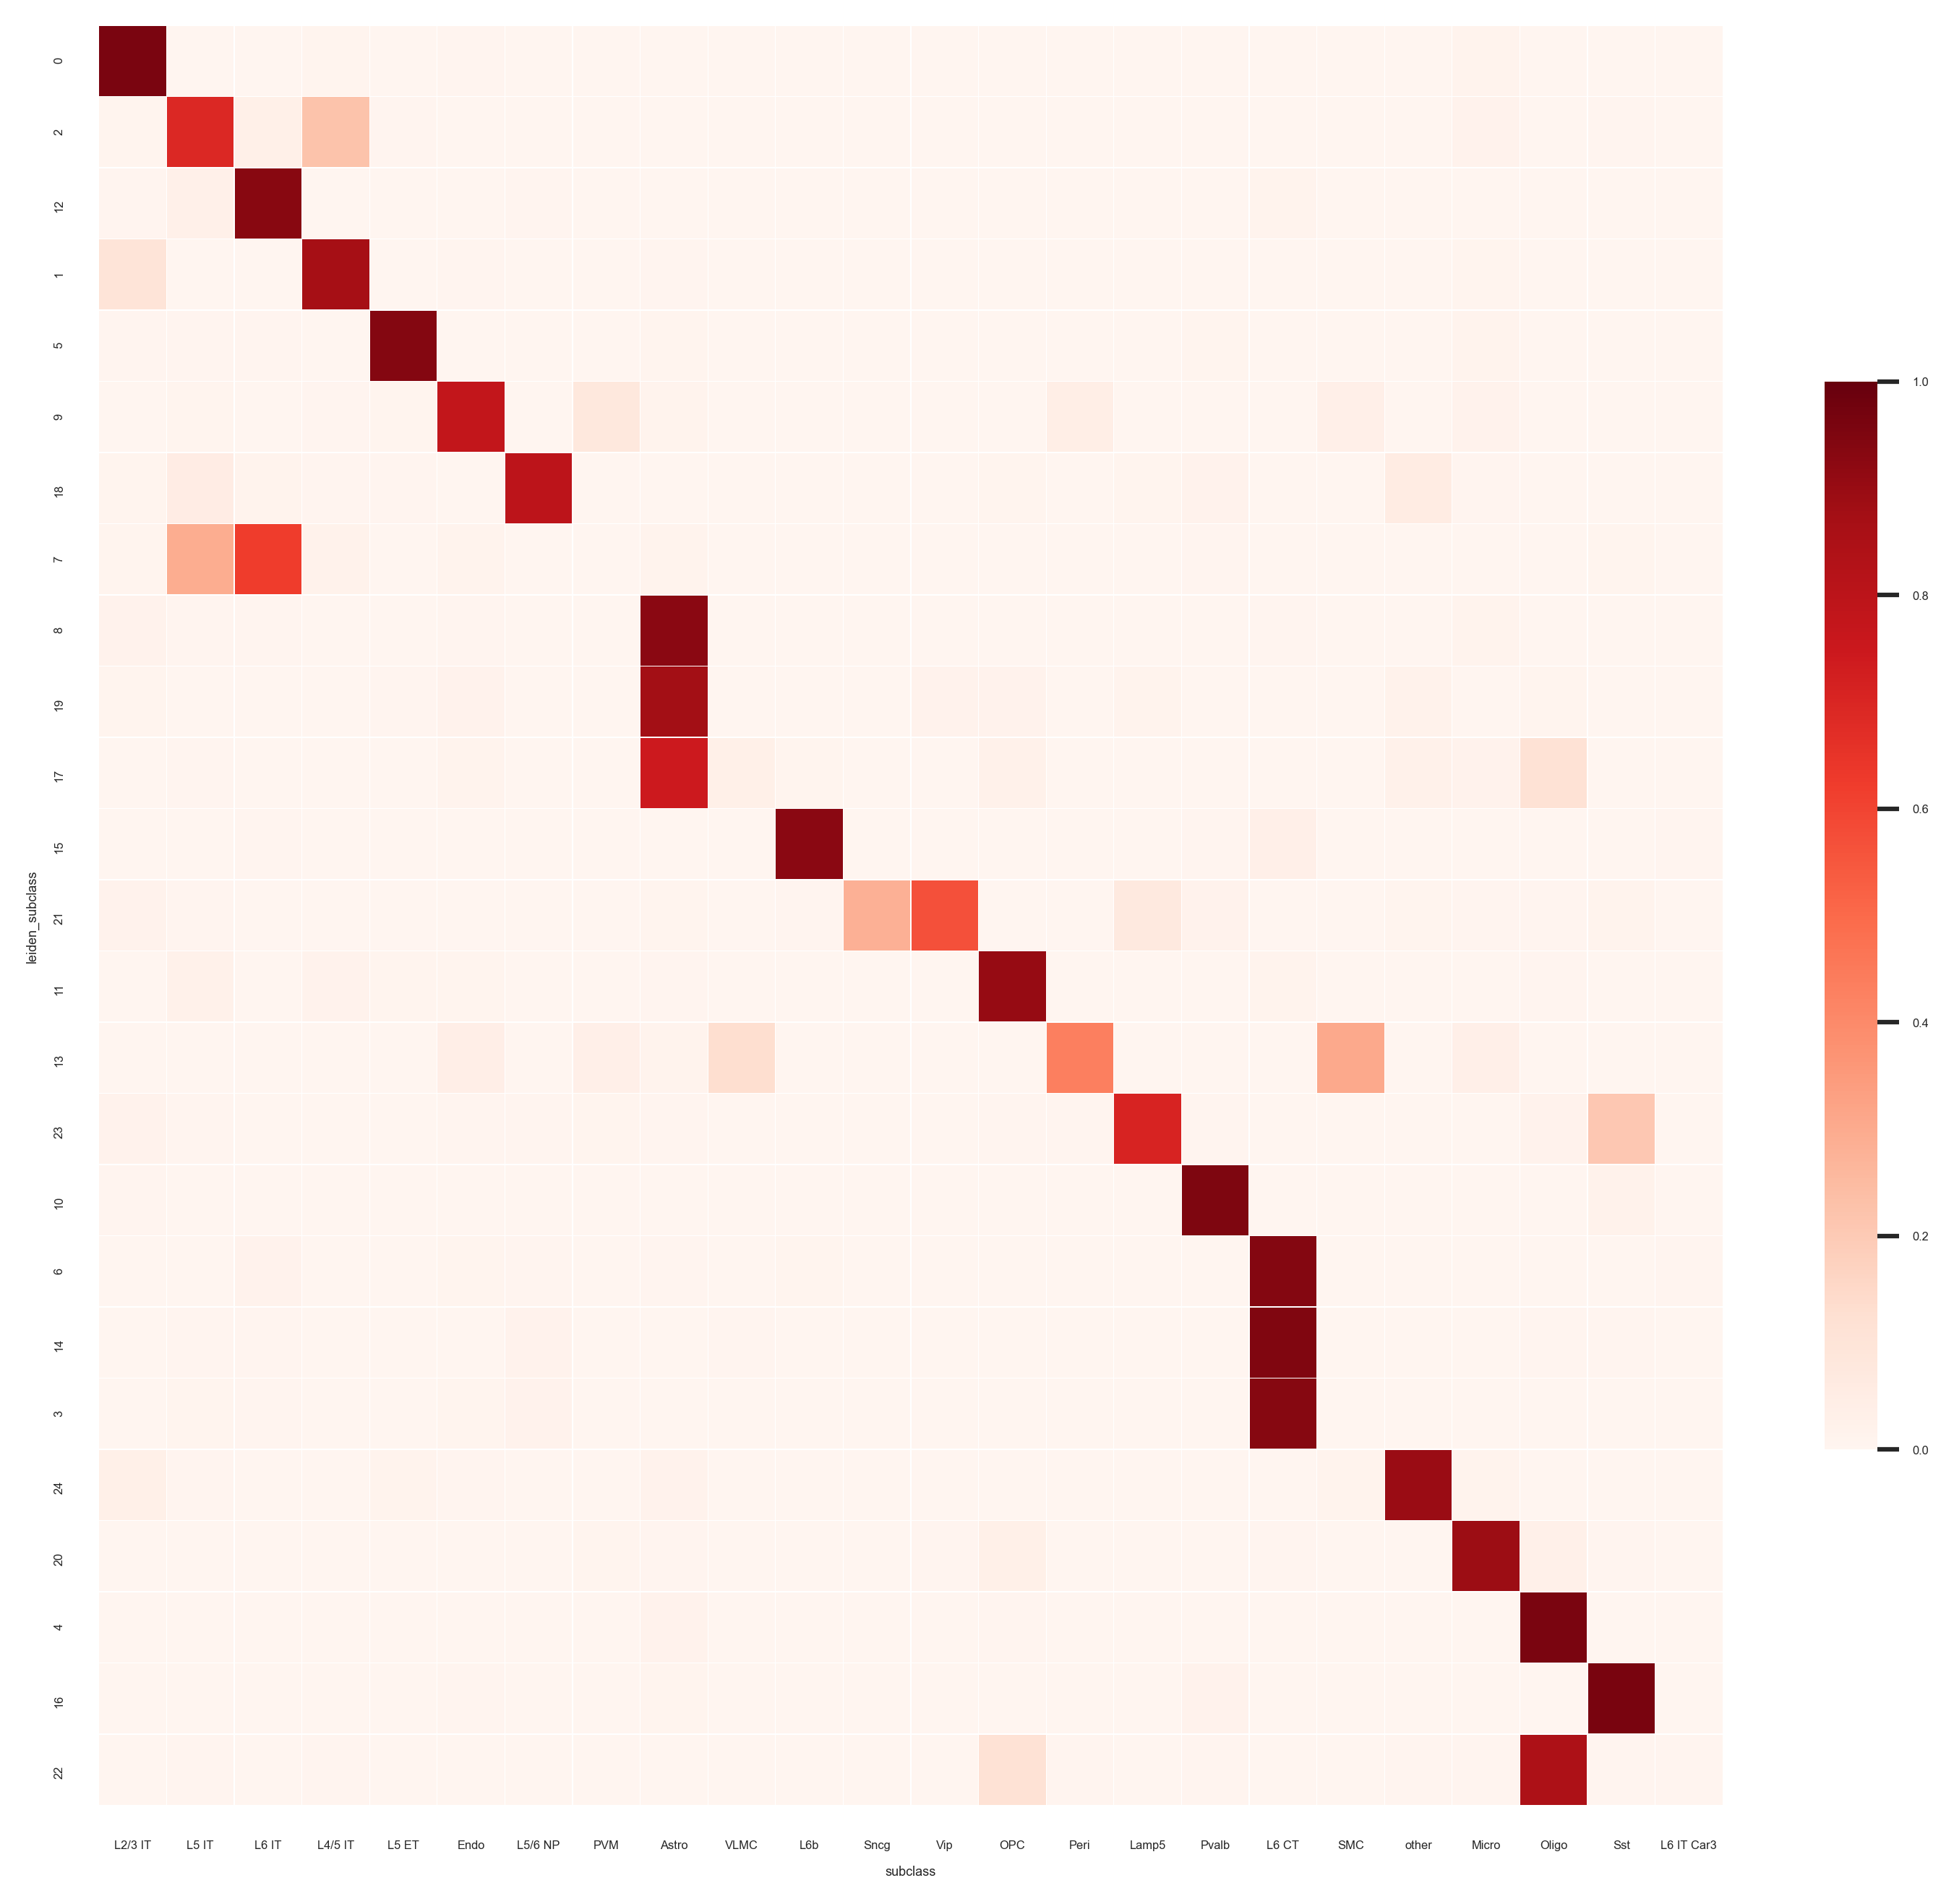

In [350]:
prediction_column = 'ref_cluster_column'

ref_cluster_column = 'subclass'

query_cluster_column = 'leiden_subclass'



print('Predict cell types.')
predict_classes(nnc, adata_query, prediction_column, genes)
    
# Count predictions
prediction_counts = adata_query.obs[[query_cluster_column, prediction_column]]
prediction_counts['count'] = 1
    
predictionMatrix = pd.pivot_table(prediction_counts, index=[query_cluster_column],
               columns=[prediction_column], values='count', aggfunc=np.sum).fillna(0)

predictionMatrix['total'] = predictionMatrix.sum(axis = 1)
    
fractions = predictionMatrix.iloc[:,:-1].div(predictionMatrix['total'],axis = 0)
    
#fractions_sorted, rows, columns = runPermutation(fractions,'Columns')
fractions_sorted, rows, columns = runPermutation(fractions,'Both')
    
# Plot
fig1=plt.figure(figsize = (10,9))
sns.set(font_scale=0.3)
#sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
sns.heatmap(fractions_sorted, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
plt.xlabel(ref_cluster_column) 
plt.ylabel(query_cluster_column)
plt.show()

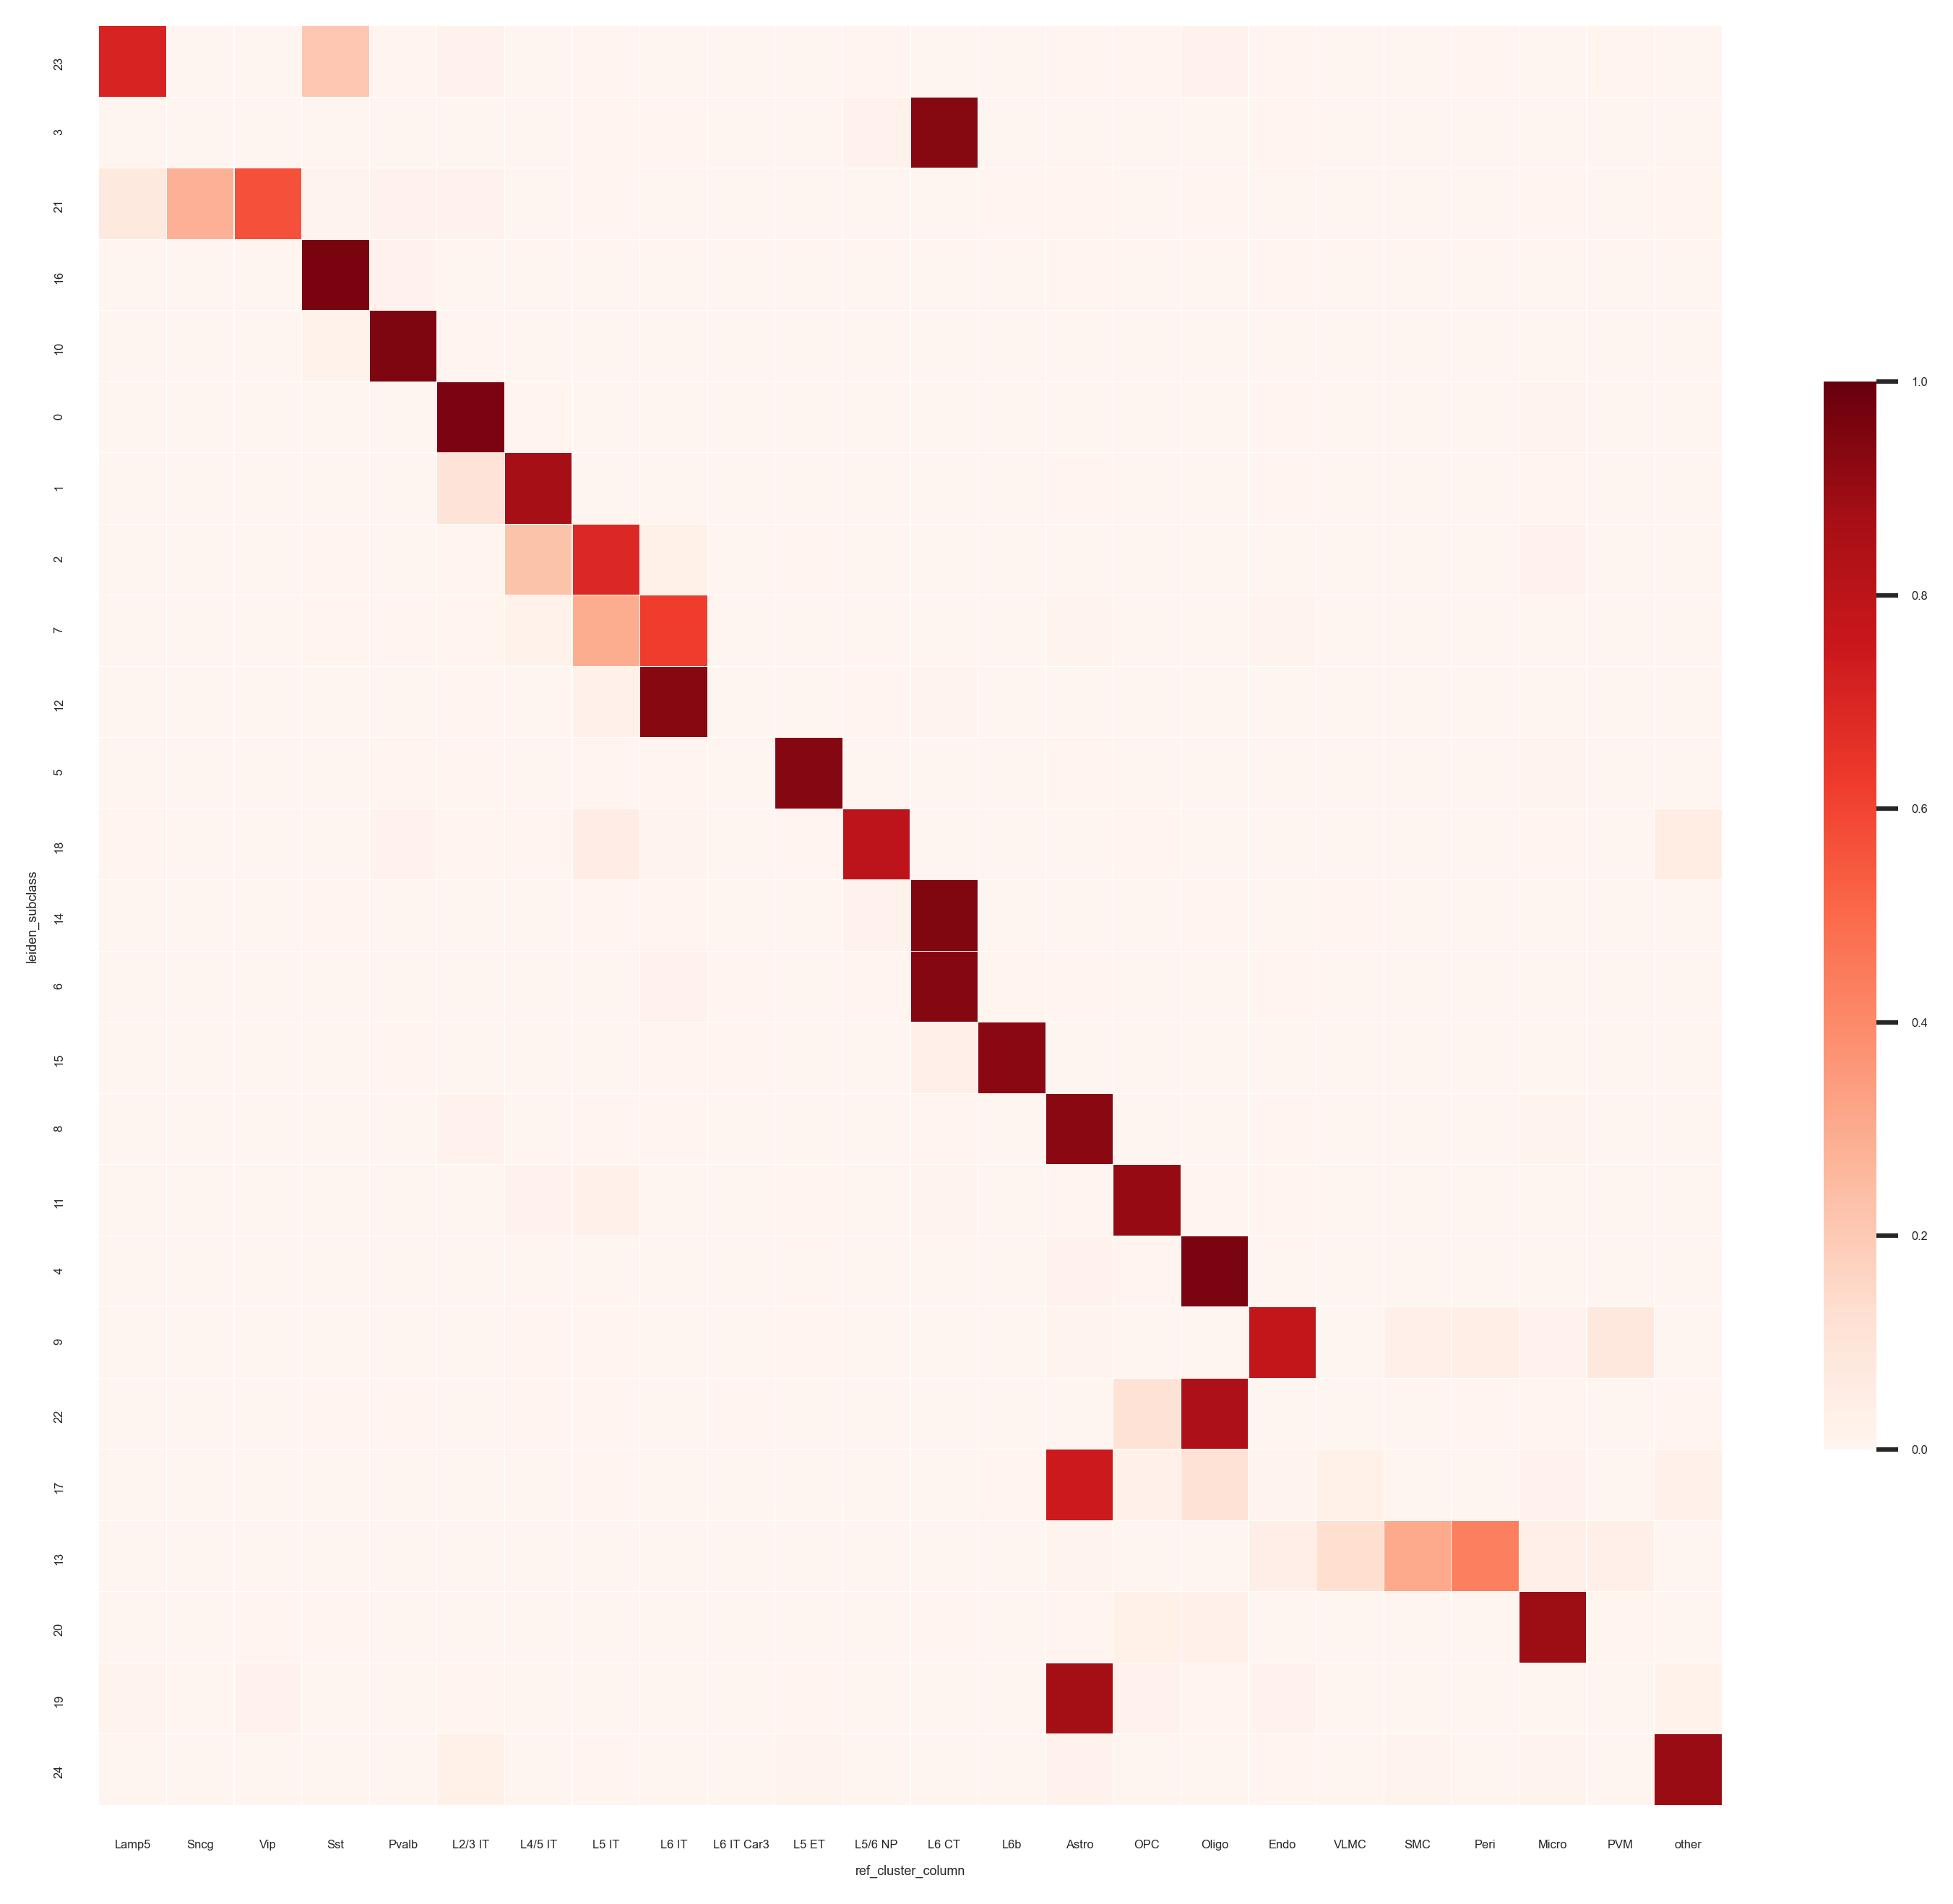

In [352]:
sorted_predicted_labels = ['Lamp5','Sncg','Vip','Sst','Pvalb','L2/3 IT','L4/5 IT','L5 IT',
                          'L6 IT','L6 IT Car3','L5 ET','L5/6 NP','L6 CT','L6b','Astro','OPC','Oligo','Endo','VLMC','SMC','Peri',
                         'Micro','PVM','other']

fractions_sorted_by_label = fractions_sorted[sorted_predicted_labels]

sorted_coor_df, rows, columns = runPermutation(fractions_sorted_by_label,'Rows',maxIter = 100,maxTrys = 15)

manual_coor_df = sorted_coor_df


_plot = True
if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    #plt.xlabel(sorted_coor_df.columns) 
    #plt.ylabel(sorted_coor_df.index)
    plt.show()

In [353]:
sorted_coor_df.index

CategoricalIndex(['23', '3', '21', '16', '10', '0', '1', '2', '7', '12', '5',
                  '18', '14', '6', '15', '8', '11', '4', '9', '22', '17', '13',
                  '20', '19', '24'],
                 categories=['0', '1', '2', '3', '4', '5', '6', '7', ...], ordered=False, name='leiden_subclass', dtype='category')

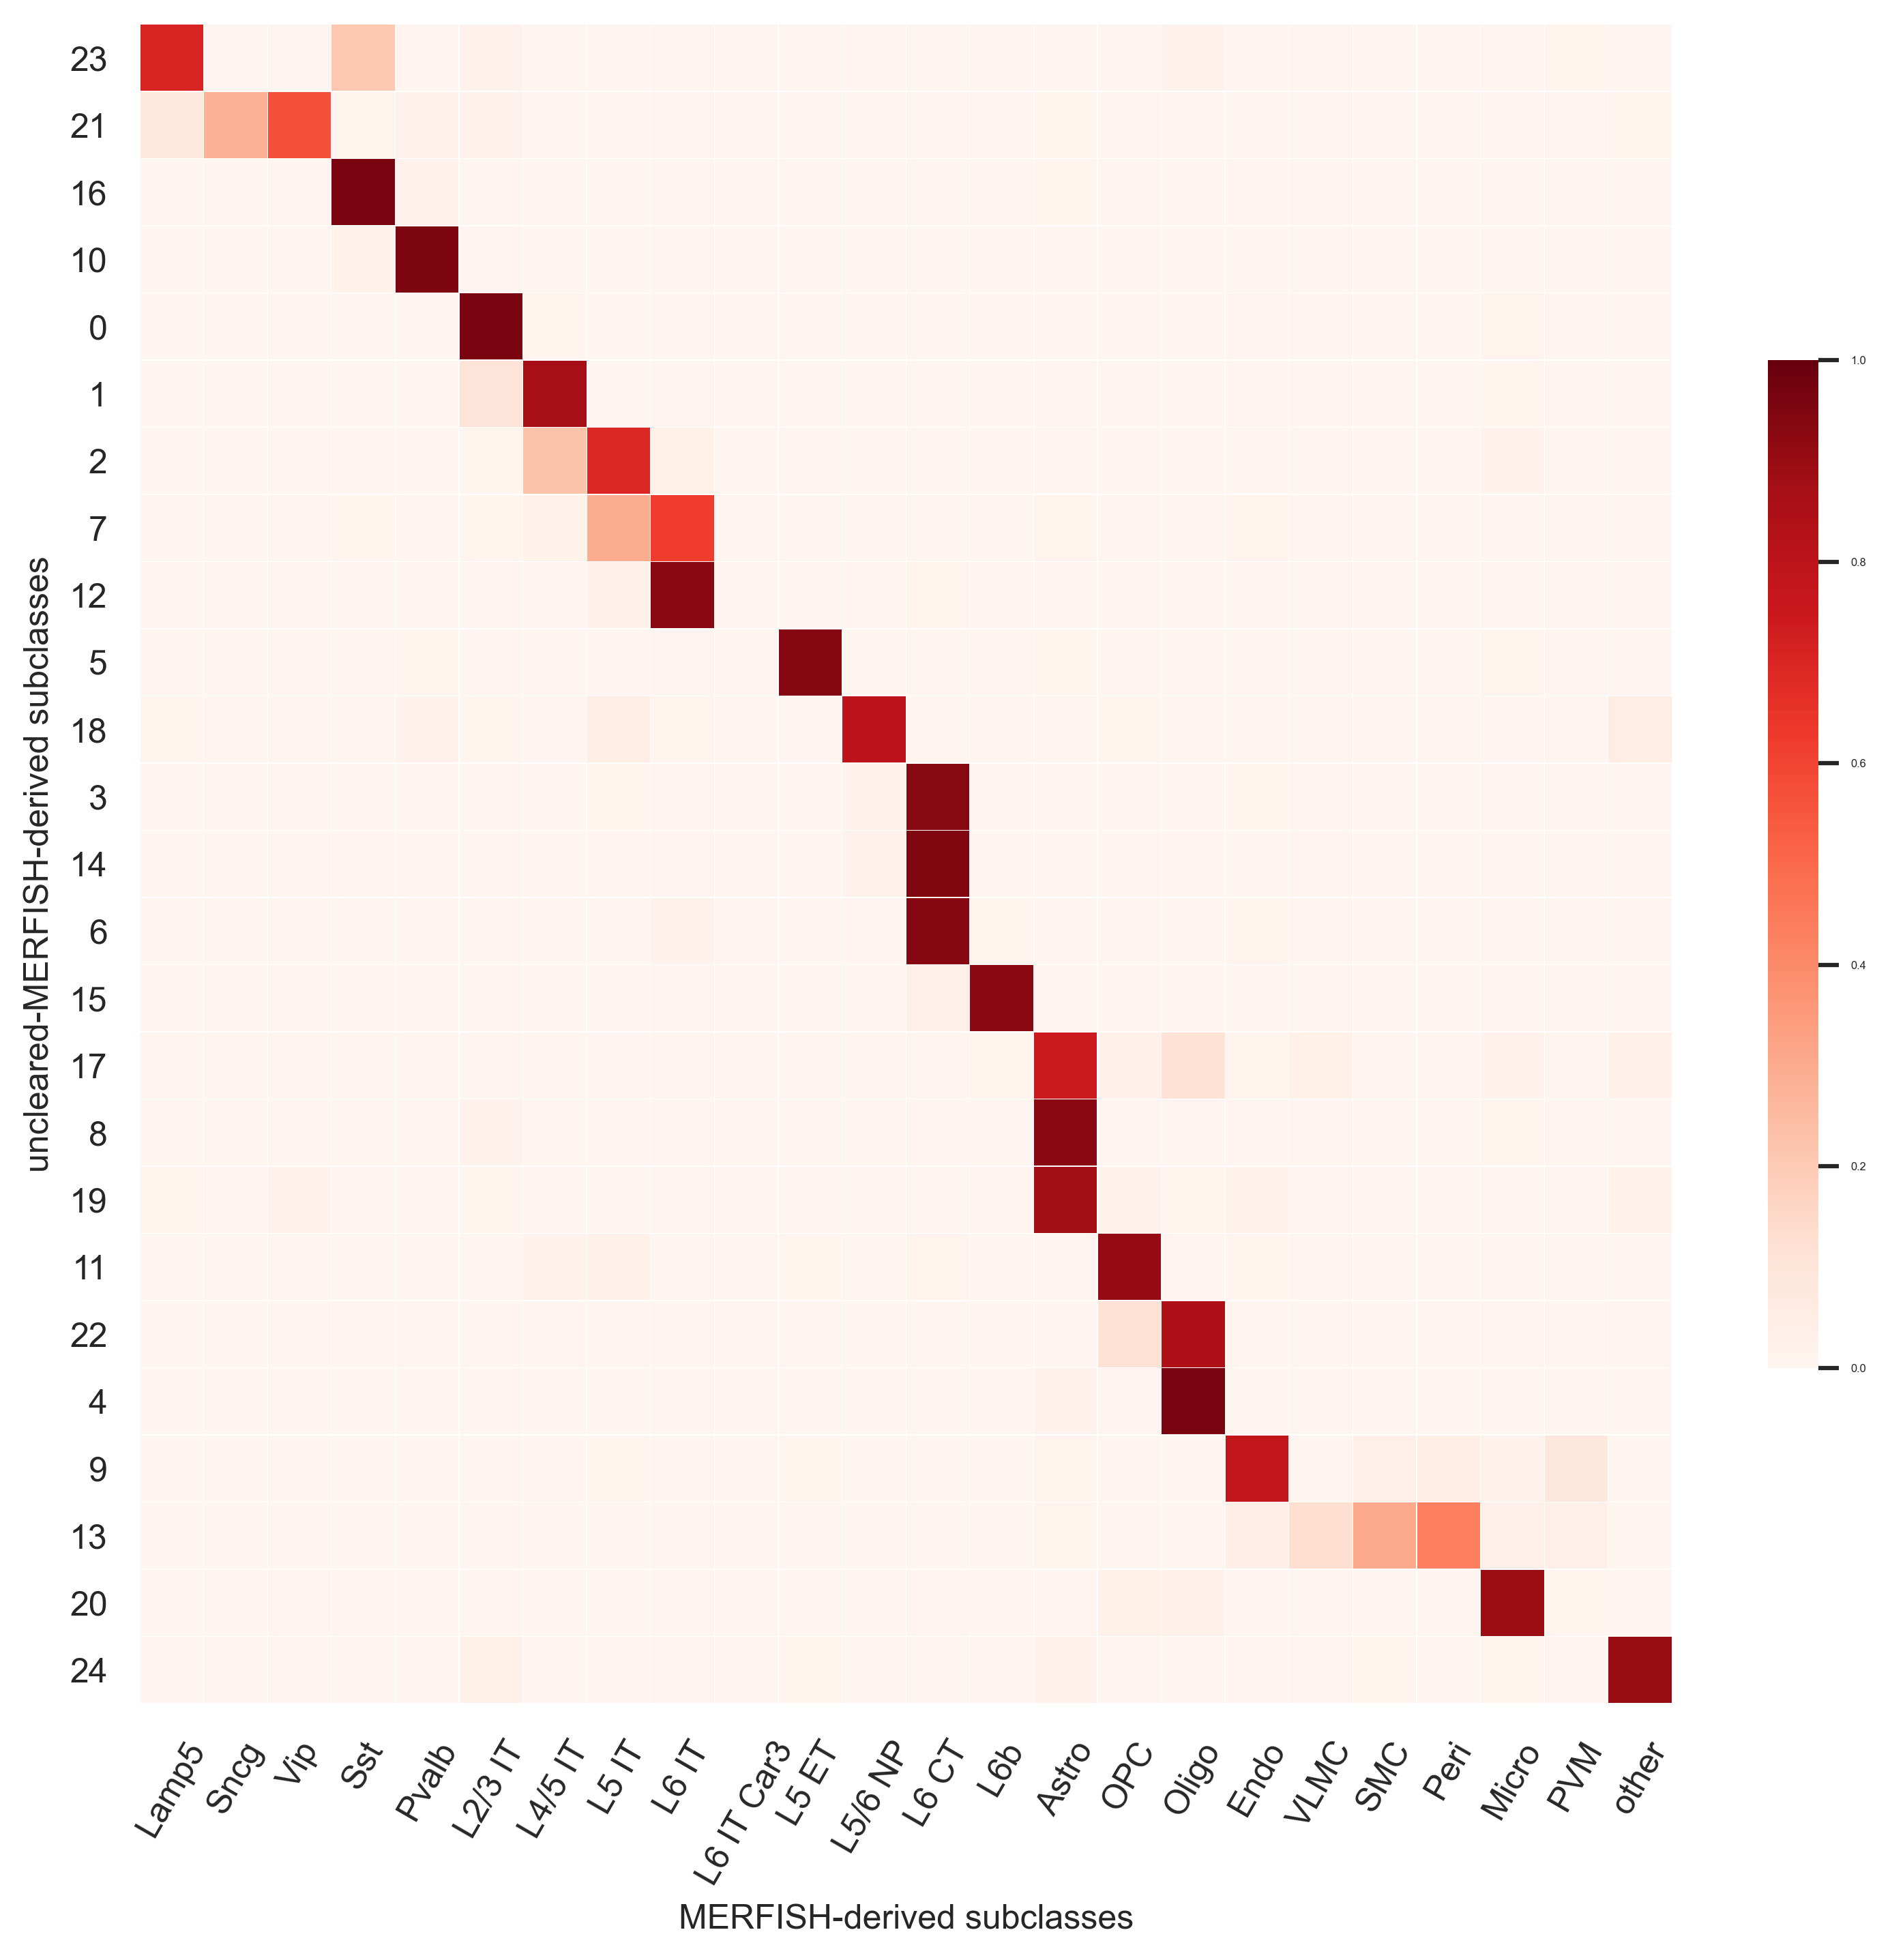

In [354]:
manual_coor_df = sorted_coor_df.reindex(['23', '21', '16', '10', '0', '1', '2', '7', '12', '5',
                  '18', '3', '14', '6', '15', '17','8', '19','11', '22','4', '9',   '13',
                  '20',  '24'])


if _plot:
   # Plot
    fig1=plt.figure(figsize = (10,9))
    sns.set(font_scale=0.3)
    #sns.heatmap(fractions_sorted, cmap='Greys', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    sns.heatmap(manual_coor_df, cmap='Reds', vmin=0, vmax=1, cbar=True, linewidths=.05,cbar_kws={"shrink": .6})
    
    
    plt.xlabel('MERFISH-derived subclasses',fontsize=10)
    plt.ylabel('uncleared-MERFISH-derived subclasses',fontsize=10)
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    plt.xticks(rotation = 60)
    plt.yticks(rotation = 'horizontal')
    plt.show()

In [367]:
manual_matrix.shape

(25, 24)

In [369]:
np.max(manual_matrix, axis=1)

array([0.71038251, 0.56854839, 0.96276596, 0.95135135, 0.95727003,
       0.8672788 , 0.6924384 , 0.62187872, 0.93023256, 0.93791574,
       0.7993921 , 0.93602103, 0.94661191, 0.93778802, 0.92639594,
       0.74468085, 0.92703349, 0.87735849, 0.90280374, 0.84684685,
       0.957814  , 0.77813505, 0.43426295, 0.89236111, 0.89677419])

In [371]:
manual_matrix = manual_coor_df.to_numpy()
manual_matrix.shape


max_cluster_sum = np.sum(np.max(manual_matrix, axis=1))

sum_of_all_elements = manual_matrix.sum()
max_cluster_sum/sum_of_all_elements

0.8401736869642581